### **Задание №1**. Предположим, что у вас в базе есть табличка с балансом по всем счетам клиента на конец дня. Из-за особенностей построения таблицы, часть значений незаполнена и физически это означает отсутствие информации об изменении баланса. Для простоты будем считать, пропущенные значения для одного пользователя не могут встретиться между двумя заполненными. Напишите SQL запрос для заполнения неизвестных значений по каждому клиенту последним известным.

client_id |date | value
--- | --- | ---
1 | 14.04.2020 | 10000
1 | 15.04.2020 | 5000
1 | 16.04.2020 | NaN
1 | 17.04.2020 | NaN
1 | 18.04.2020 | NaN
2 | 14.04.2020 | 250000
2 | 15.04.2020 | 250000
2 | 16.04.2020 | 230000
2 | 17.04.2020 | 230000
2 | 18.04.2020 | 225000
3 | 14.04.2020 | 50000
3 | 15.04.2020 | NaN
3 | 16.04.2020 | NaN
3 | 17.04.2020 | NaN
3 | 18.04.2020 | NaN


In [ ]:
# <YOUR_CODE_HERE>
# если под "последним известным" имеется в виду значение, которое встретилось в последний день, то:
UPDATE t1
SET value = t2.value FROM (SELECT MAX(date), client_id, value FROM t1 WHERE value IS NOT NULL GROUP BY client_id) AS t2
WHERE t1.value IS NULL AND t2.client_id = t1.client_id
;

In [ ]:
# вариант с оконной функцией
UPDATE t1
SET value = t2.last_value FROM (SELECT client_id, value, LAST_VALUE(value) OVER (PARTITION BY client_id) AS last_value FROM t1 WHERE value IS NOT NULL) AS t2
WHERE t1.value IS NULL AND t1.client_id = t2.client_id
;

### **Задание №1.1 (*)**. В прошлом задании мы считали, что пропущенные значения не могут находиться между двумя заполненными в рамках одного пользователя, что не всегда правда в реальных задачах. Напишите теперь SQL запрос без указанного допущения.

client_id |date | value
--- | --- | ---
1 | 14.04.2020 | 10000
1 | 15.04.2020 | 5000
1 | 16.04.2020 | NaN
1 | 17.04.2020 | 7000
1 | 18.04.2020 | NaN
2 | 14.04.2020 | 250000
2 | 15.04.2020 | 250000
2 | 16.04.2020 | 230000
2 | 17.04.2020 | 230000
2 | 18.04.2020 | 225000
3 | 14.04.2020 | 50000
3 | 15.04.2020 | NaN
3 | 16.04.2020 | NaN
3 | 17.04.2020 | 49000
3 | 18.04.2020 | NaN

In [ ]:
# <YOUR_CODE_HERE>
UPDATE task1
SET value = t2.last_value FROM (SELECT client_id, value, LAST_VALUE(value) OVER (PARTITION BY client_id ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) AS last_value FROM task1 WHERE value IS NOT NULL) AS t2
WHERE task1.value IS NULL AND task1.client_id = t2.client_id

### **Задание №2**. Пусть клиенты обладают рядом статусов, закодированных цифрами: 0 - "улица", 1 - "зарплатник", 2 - "премиум", 3 - "пенсионер", 4 - "студент". У нас есть матрица с логами смен статусов за некоторый период, разверните ее в матрицу статус - статус с частотами перехода между ними.

Пример, как было:

client_id | prev_segment | new_segment|
--- | --- | ---
1 | 0 | 1
2 | 0 | 2
3 | 4 | 3

Пример, как нужно:

segment |0 | 1 | 2 | 3 | 4 
--- | --- | --- | --- | --- | ---
0 | 0 | 0.5 | 0.5 | 0 | 0 
1 | 0 |0 | 0 | 0 | 0
2 | 0 | 0 | 0 | 0 | 0
3 | 0 | 0 | 0 | 0 | 0
4 | 0 | 0 | 0 | 1 | 0

В процессе выполнения задания разрешается пользоваться библиотеками numpy и pandas.

In [1]:
import numpy as np
import pandas as pd

# Сгенерируем данные для задачи
data = pd.DataFrame(
    np.random.randint(low=0, high=5, size=(50000000, 2)),
    columns=['prev_segment', 'new_segment']
)

# <YOUR_CODE_HERE>
segments = pd.unique(data['prev_segment'])
x = np.zeros((len(segments), len(segments)))
for i in segments:
    for j in segments:
        x[i][j] = data[(data['prev_segment'] == i) & (data['new_segment'] == j)].shape[0] / data[data['prev_segment'] == i].shape[0]
m = pd.DataFrame(data = x)
m

,0,1,2,3,4
0,0.199998,0.199997,0.200143,0.199779,0.200083
1,0.199869,0.200200,0.199940,0.199973,0.200018
2,0.200058,0.199892,0.200086,0.199982,0.199982
3,0.200032,0.199810,0.200008,0.199969,0.200181
4,0.199977,0.200244,0.199905,0.199943,0.199930


### **Задание №2.1 (*)**. Если вы не пользовались библиотечными функциями и реализовывали алгоритм самостоятельно, напишите, пожалуйста, его асимптотическую сложность в терминах O-большое.

In [ ]:
# <YOUR_CODE_HERE>

### **Задание №3**. Постройте прогнозую модель для датасета с UCI Machine Learning: предобработайте категориальные фичи, отберите их, соберите схему валидации и отберите модели с помощью нее. Описание датасета по ссылке: https://archive.ics.uci.edu/ml/datasets/Drug+consumption+%28quantified%29

Данная задача multilabel multiclass classification, поэтому предлагаю начать с одного из подходов:
- Свести задачу к multilabel binary classification, как это указано в описании к датасету;
- Свести задачку к binary classification тем или иным способом;
- Обучить множество multiclass/binary classification моделей;
- Что-то еще, что придет в голову.


In [2]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00373/drug_consumption.data

--2023-02-19 08:18:31--  https://archive.ics.uci.edu/ml/machine-learning-databases/00373/drug_consumption.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 346695 (339K) [application/x-httpd-php]
Saving to: ‘drug_consumption.data’

drug_consumption.da 100%[===================>] 338.57K  1.27MB/s    in 0.3s    

2023-02-19 08:18:31 (1.27 MB/s) - ‘drug_consumption.data’ saved [346695/346695]



In [138]:
import numpy as np
import pandas as pd

data = pd.read_csv('drug_consumption.data', header=None, index_col=0)
data.head()

,1,2,3,4,5,6,7,8,9,10,...,22,23,24,25,26,27,28,29,30,31
0,,,,,,,,,,,,,,,,,,,,,
1,0.49788,0.48246,-0.05921,0.96082,0.12600,0.31287,-0.57545,-0.58331,-0.91699,-0.00665,...,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL2,CL0,CL0
2,-0.07854,-0.48246,1.98437,0.96082,-0.31685,-0.67825,1.93886,1.43533,0.76096,-0.14277,...,CL4,CL0,CL2,CL0,CL2,CL3,CL0,CL4,CL0,CL0
3,0.49788,-0.48246,-0.05921,0.96082,-0.31685,-0.46725,0.80523,-0.84732,-1.62090,-1.01450,...,CL0,CL0,CL0,CL0,CL0,CL0,CL1,CL0,CL0,CL0
4,-0.95197,0.48246,1.16365,0.96082,-0.31685,-0.14882,-0.80615,-0.01928,0.59042,0.58489,...,CL0,CL0,CL2,CL0,CL0,CL0,CL0,CL2,CL0,CL0
5,0.49788,0.48246,1.98437,0.96082,-0.31685,0.73545,-1.63340,-0.45174,-0.30172,1.30612,...,CL1,CL0,CL0,CL1,CL0,CL0,CL2,CL2,CL0,CL0


In [139]:
#Переименуем столбцы, потому что не очень понятно, что это за фичи
columns = ['Age', 'Gender', 'Education', 'Country', 'Ethnicity', 'Neuroticism', 'Extraversion', 'Openness', 'Agreeableness', 
            'Conscientiousness', 'Impulsiveness', 'SS', 'Alcohol', 'Amphet', 'Amyl', 'Benzos', 'Caff', 'Cannabis', 'Choc',
            'Coke', 'Crack', 'Ecstasy', 'Heroin', 'Ketamine', 'LegalH', 'LSD', 'Meth', 'Mushrooms', 'Nicotine', 'Semer', 'VSA']
data.columns=columns
data.head()

,Age,Gender,Education,Country,Ethnicity,Neuroticism,Extraversion,Openness,Agreeableness,Conscientiousness,...,Ecstasy,Heroin,Ketamine,LegalH,LSD,Meth,Mushrooms,Nicotine,Semer,VSA
0,,,,,,,,,,,,,,,,,,,,,
1,0.49788,0.48246,-0.05921,0.96082,0.12600,0.31287,-0.57545,-0.58331,-0.91699,-0.00665,...,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL2,CL0,CL0
2,-0.07854,-0.48246,1.98437,0.96082,-0.31685,-0.67825,1.93886,1.43533,0.76096,-0.14277,...,CL4,CL0,CL2,CL0,CL2,CL3,CL0,CL4,CL0,CL0
3,0.49788,-0.48246,-0.05921,0.96082,-0.31685,-0.46725,0.80523,-0.84732,-1.62090,-1.01450,...,CL0,CL0,CL0,CL0,CL0,CL0,CL1,CL0,CL0,CL0
4,-0.95197,0.48246,1.16365,0.96082,-0.31685,-0.14882,-0.80615,-0.01928,0.59042,0.58489,...,CL0,CL0,CL2,CL0,CL0,CL0,CL0,CL2,CL0,CL0
5,0.49788,0.48246,1.98437,0.96082,-0.31685,0.73545,-1.63340,-0.45174,-0.30172,1.30612,...,CL1,CL0,CL0,CL1,CL0,CL0,CL2,CL2,CL0,CL0


In [140]:
#проверим данные на наличие пропусков
data.isnull().sum()

Age                  0
Gender               0
Education            0
Country              0
Ethnicity            0
Neuroticism          0
Extraversion         0
Openness             0
Agreeableness        0
Conscientiousness    0
Impulsiveness        0
SS                   0
Alcohol              0
Amphet               0
Amyl                 0
Benzos               0
Caff                 0
Cannabis             0
Choc                 0
Coke                 0
Crack                0
Ecstasy              0
Heroin               0
Ketamine             0
LegalH               0
LSD                  0
Meth                 0
Mushrooms            0
Nicotine             0
Semer                0
VSA                  0
dtype: int64

In [141]:
drugs = ['Alcohol', 'Amphet', 'Amyl', 'Benzos', 'Caff', 'Cannabis', 'Choc',
      'Coke', 'Crack', 'Ecstasy', 'Heroin', 'Ketamine', 'LegalH', 'LSD', 'Meth', 
      'Mushrooms', 'Nicotine', 'Semer', 'VSA']
drugs_df = data[drugs]
drugs_df.head()

,Alcohol,Amphet,Amyl,Benzos,Caff,Cannabis,Choc,Coke,Crack,Ecstasy,Heroin,Ketamine,LegalH,LSD,Meth,Mushrooms,Nicotine,Semer,VSA
0,,,,,,,,,,,,,,,,,,,
1,CL5,CL2,CL0,CL2,CL6,CL0,CL5,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL2,CL0,CL0
2,CL5,CL2,CL2,CL0,CL6,CL4,CL6,CL3,CL0,CL4,CL0,CL2,CL0,CL2,CL3,CL0,CL4,CL0,CL0
3,CL6,CL0,CL0,CL0,CL6,CL3,CL4,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL1,CL0,CL0,CL0
4,CL4,CL0,CL0,CL3,CL5,CL2,CL4,CL2,CL0,CL0,CL0,CL2,CL0,CL0,CL0,CL0,CL2,CL0,CL0
5,CL4,CL1,CL1,CL0,CL6,CL3,CL6,CL0,CL0,CL1,CL0,CL0,CL1,CL0,CL0,CL2,CL2,CL0,CL0


In [142]:
import matplotlib.pyplot as plt
import seaborn as sns

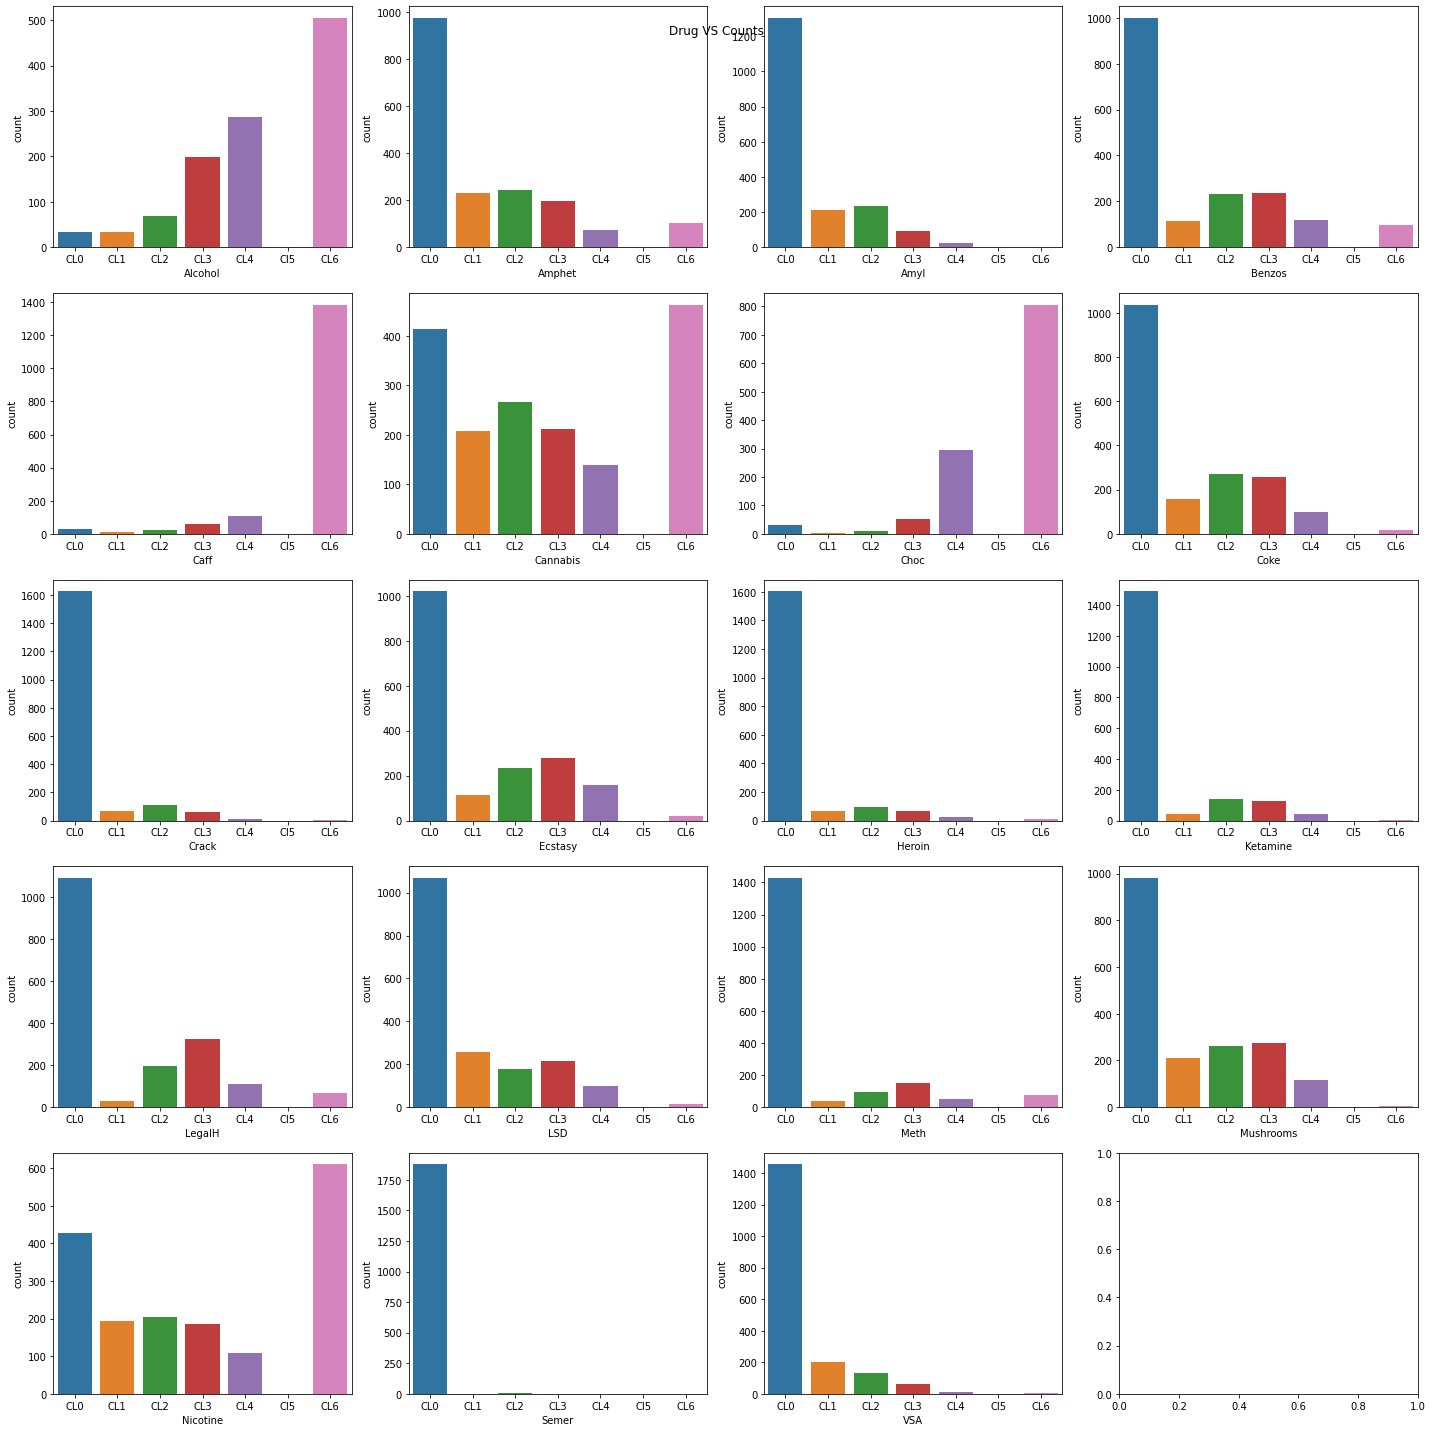

In [143]:
# Посмотрим, как распределяется по классам употребление того или иного вещества
fig, ax = plt.subplots(5,4,figsize = (20,20))
fig.suptitle("Drug VS Counts")
axe = ax.ravel()
for i, drug in enumerate(drugs):
  sns.countplot(x=drug, data=drugs_df,order = ['CL0', 'CL1', 'CL2', 'CL3', 'CL4', 'Cl5', 'CL6'], ax=axe[i])
plt.subplots_adjust(bottom=0, right=0.8, top=1)
plt.tight_layout(pad=1.08)
plt.show()

In [144]:
# В зависимости от того, какую задачу мы хотим решать, категориальные фичи можно пробразовать по-разному
# Я предлагаю преобразовать решать задачу бинарной классификации, предложенную в описании датасета
# For example, "Never Used", "Used over a Decade Ago" form class "Non-user" and all other classes form class "User"
# Заменим строки на 0 и 1 (Non-User и User)
 
data = data.replace({'CL0': 0, 'CL1':0, 'CL2':1, 'CL3':1, 'CL4':1, 'CL5':1, 'CL6':1})
data.head()

,Age,Gender,Education,Country,Ethnicity,Neuroticism,Extraversion,Openness,Agreeableness,Conscientiousness,...,Ecstasy,Heroin,Ketamine,LegalH,LSD,Meth,Mushrooms,Nicotine,Semer,VSA
0,,,,,,,,,,,,,,,,,,,,,
1,0.49788,0.48246,-0.05921,0.96082,0.12600,0.31287,-0.57545,-0.58331,-0.91699,-0.00665,...,0,0,0,0,0,0,0,1,0,0
2,-0.07854,-0.48246,1.98437,0.96082,-0.31685,-0.67825,1.93886,1.43533,0.76096,-0.14277,...,1,0,1,0,1,1,0,1,0,0
3,0.49788,-0.48246,-0.05921,0.96082,-0.31685,-0.46725,0.80523,-0.84732,-1.62090,-1.01450,...,0,0,0,0,0,0,0,0,0,0
4,-0.95197,0.48246,1.16365,0.96082,-0.31685,-0.14882,-0.80615,-0.01928,0.59042,0.58489,...,0,0,1,0,0,0,0,1,0,0
5,0.49788,0.48246,1.98437,0.96082,-0.31685,0.73545,-1.63340,-0.45174,-0.30172,1.30612,...,0,0,0,0,0,0,1,1,0,0


In [145]:
data[drugs].describe()

,Alcohol,Amphet,Amyl,Benzos,Caff,Cannabis,Choc,Coke,Crack,Ecstasy,Heroin,Ketamine,LegalH,LSD,Meth,Mushrooms,Nicotine,Semer,VSA
count,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000
mean,0.963926,0.360212,0.196286,0.407958,0.980371,0.671088,0.981432,0.364456,0.101326,0.398408,0.112467,0.185676,0.404244,0.295491,0.221220,0.368170,0.670557,0.003183,0.122016
std,0.186524,0.480189,0.397293,0.491586,0.138757,0.469943,0.135028,0.481405,0.301840,0.489700,0.316024,0.388948,0.490875,0.456384,0.415179,0.482436,0.470136,0.056343,0.327391
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [146]:
data[drugs].sum()

Alcohol      1817
Amphet        679
Amyl          370
Benzos        769
Caff         1848
Cannabis     1265
Choc         1850
Coke          687
Crack         191
Ecstasy       751
Heroin        212
Ketamine      350
LegalH        762
LSD           557
Meth          417
Mushrooms     694
Nicotine     1264
Semer           6
VSA           230
dtype: int64

Ожидаемо, алкоголь, шоколад и кофеин - это самые употребляемые вещества, почти каждый респондент их употреблял в течение последних 10 лет.
Шесть человек сказали, что употребляли вымышленный наркотик Semeron. 

In [147]:
data[data['Semer'] == 1][drugs]

,Alcohol,Amphet,Amyl,Benzos,Caff,Cannabis,Choc,Coke,Crack,Ecstasy,Heroin,Ketamine,LegalH,LSD,Meth,Mushrooms,Nicotine,Semer,VSA
0,,,,,,,,,,,,,,,,,,,
730,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1
821,1,0,0,0,1,1,1,0,0,1,0,0,0,1,0,1,1,1,0
1520,0,1,1,1,1,1,0,1,1,0,1,0,1,0,1,1,1,1,0
1537,1,1,0,1,1,1,1,1,0,1,0,1,1,1,0,1,1,1,1
1702,1,0,0,1,1,1,1,1,0,1,0,1,1,1,0,1,1,1,0
1827,1,0,0,1,1,1,1,1,0,0,0,0,1,1,0,1,1,1,0


Предлагаю убрать из выборки данные респондентов, которые сказали, что употребляли вымышленный наркотик, т.к. их ответы недостоверны, а затем убрать его из списка.

In [148]:
semer_users = data[data['Semer'] == 1][drugs].index

In [149]:
semer_users

Int64Index([730, 821, 1520, 1537, 1702, 1827], dtype='int64', name=0)

In [150]:
data = data.drop(semer_users, axis=0)
data = data.drop('Semer', axis=1)
drugs_df = drugs_df.drop(semer_users, axis=0)
drugs_df = drugs_df.drop('Semer', axis=1)
drugs.remove('Semer')
#data = data.reset_index() ### теряем реальные id, но sclearn будет ругаться, ели этого не сделать



In [152]:
data.head()

,Age,Gender,Education,Country,Ethnicity,Neuroticism,Extraversion,Openness,Agreeableness,Conscientiousness,...,Crack,Ecstasy,Heroin,Ketamine,LegalH,LSD,Meth,Mushrooms,Nicotine,VSA
0,,,,,,,,,,,,,,,,,,,,,
1,0.49788,0.48246,-0.05921,0.96082,0.12600,0.31287,-0.57545,-0.58331,-0.91699,-0.00665,...,0,0,0,0,0,0,0,0,1,0
2,-0.07854,-0.48246,1.98437,0.96082,-0.31685,-0.67825,1.93886,1.43533,0.76096,-0.14277,...,0,1,0,1,0,1,1,0,1,0
3,0.49788,-0.48246,-0.05921,0.96082,-0.31685,-0.46725,0.80523,-0.84732,-1.62090,-1.01450,...,0,0,0,0,0,0,0,0,0,0
4,-0.95197,0.48246,1.16365,0.96082,-0.31685,-0.14882,-0.80615,-0.01928,0.59042,0.58489,...,0,0,0,1,0,0,0,0,1,0
5,0.49788,0.48246,1.98437,0.96082,-0.31685,0.73545,-1.63340,-0.45174,-0.30172,1.30612,...,0,0,0,0,0,0,0,1,1,0


In [155]:
drugs_df.shape

(1879, 18)

In [156]:
data.shape

(1879, 30)

In [154]:
data[drugs].head()

,Alcohol,Amphet,Amyl,Benzos,Caff,Cannabis,Choc,Coke,Crack,Ecstasy,Heroin,Ketamine,LegalH,LSD,Meth,Mushrooms,Nicotine,VSA
0,,,,,,,,,,,,,,,,,,
1,1,1,0,1,1,0,1,0,0,0,0,0,0,0,0,0,1,0
2,1,1,1,0,1,1,1,1,0,1,0,1,0,1,1,0,1,0
3,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0
4,1,0,0,1,1,1,1,1,0,0,0,1,0,0,0,0,1,0
5,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,1,1,0


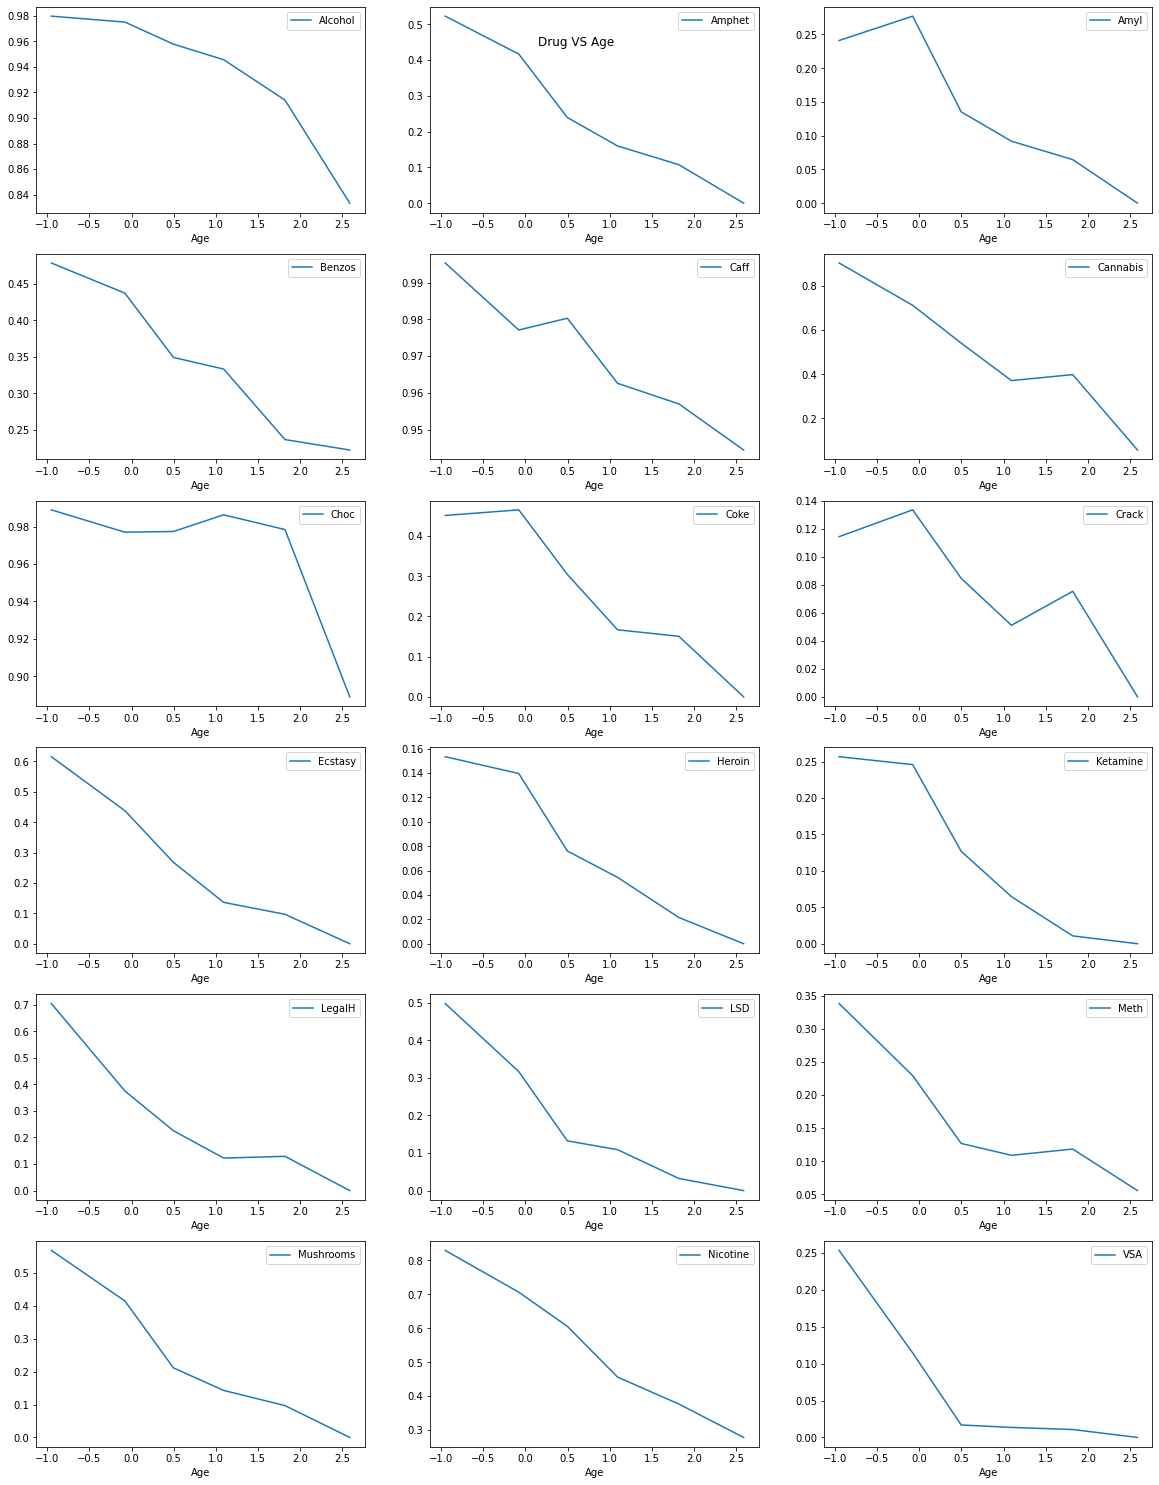

In [157]:
# Посмотрим, как меняется употребление наркотических веществ с возрастом
fig, ax = plt.subplots(6,3,figsize = (20,20))
fig.suptitle("Drug VS Age")
axe = ax.ravel()
for i, drug in enumerate(drugs):
  data[[drug,'Age']].groupby(['Age']).mean().plot(ax=axe[i])
plt.subplots_adjust(bottom=0,  top=1)
plt.show()


К старости люди перестают употреблять, но шоколад едят  :)

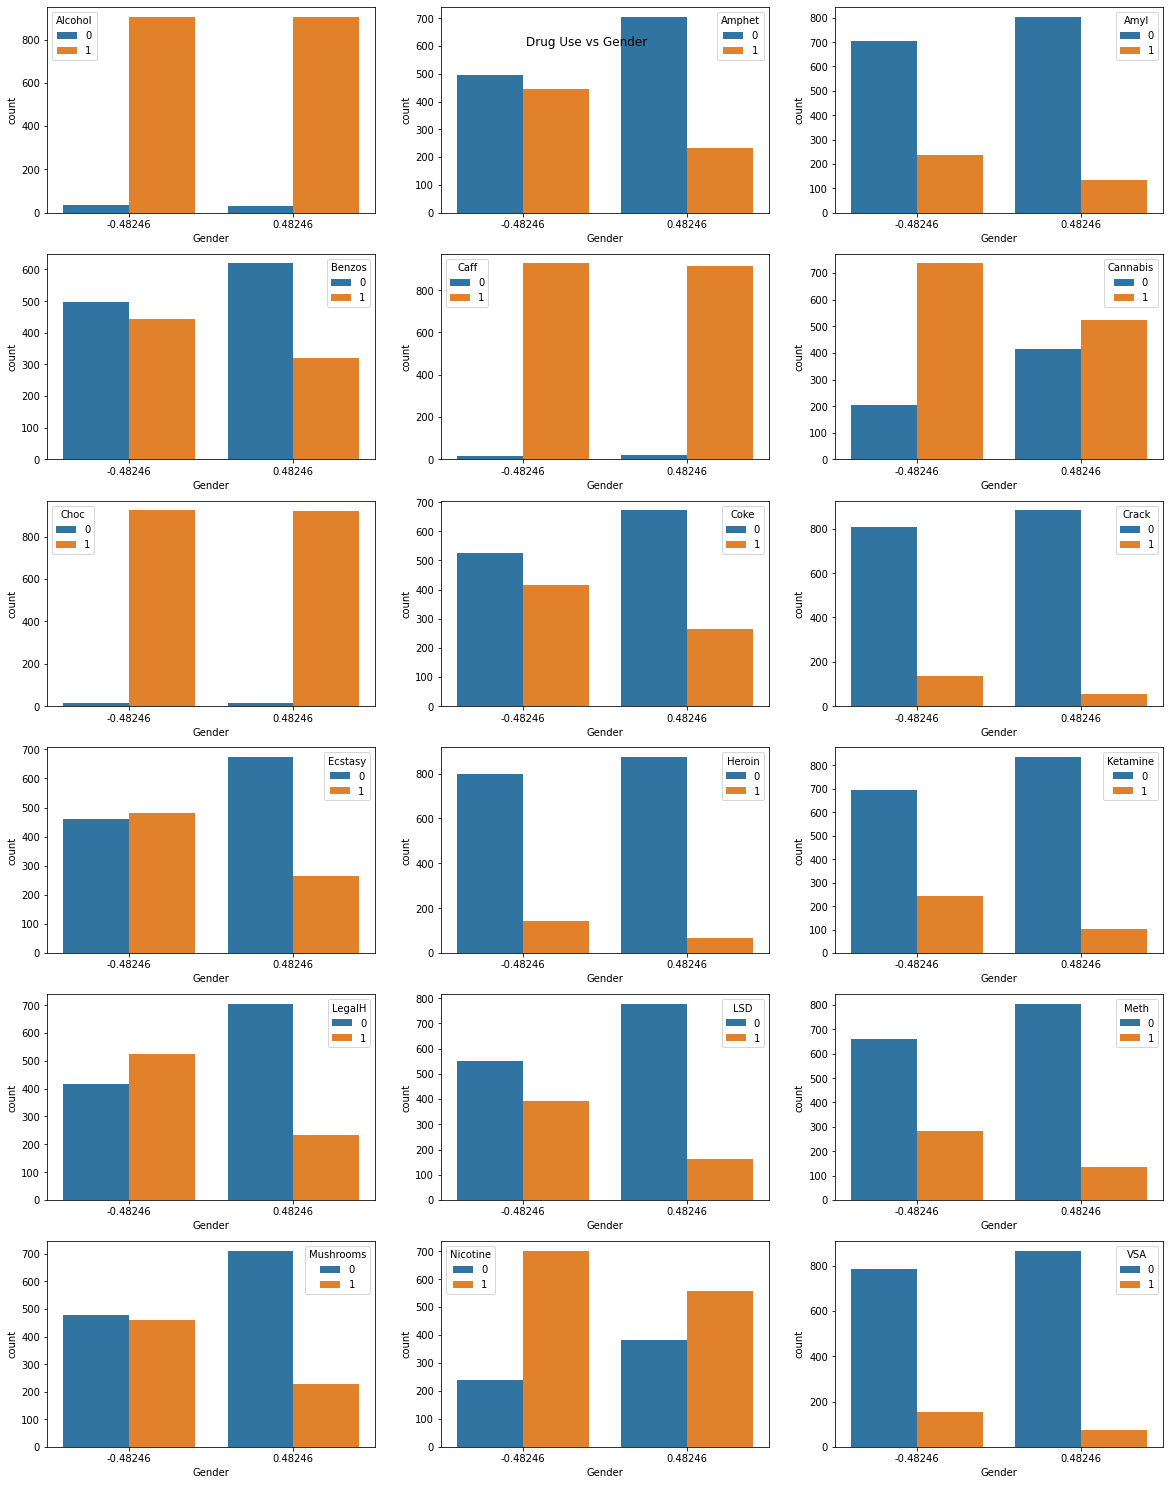

In [158]:
# Посмотрим, что с полом
# 0.48246 Female 942 49.97%
# -0.48246 Male 943 50.03%
fig, ax = plt.subplots(6,3,figsize = (20,20))
fig.suptitle("Drug Use vs Gender")
axe = ax.ravel()
for i, drug in enumerate(drugs):
  sns.countplot(x='Gender',hue=drug,data=data,ax=axe[i])
  
plt.subplots_adjust(bottom=0, top=1)
plt.show()


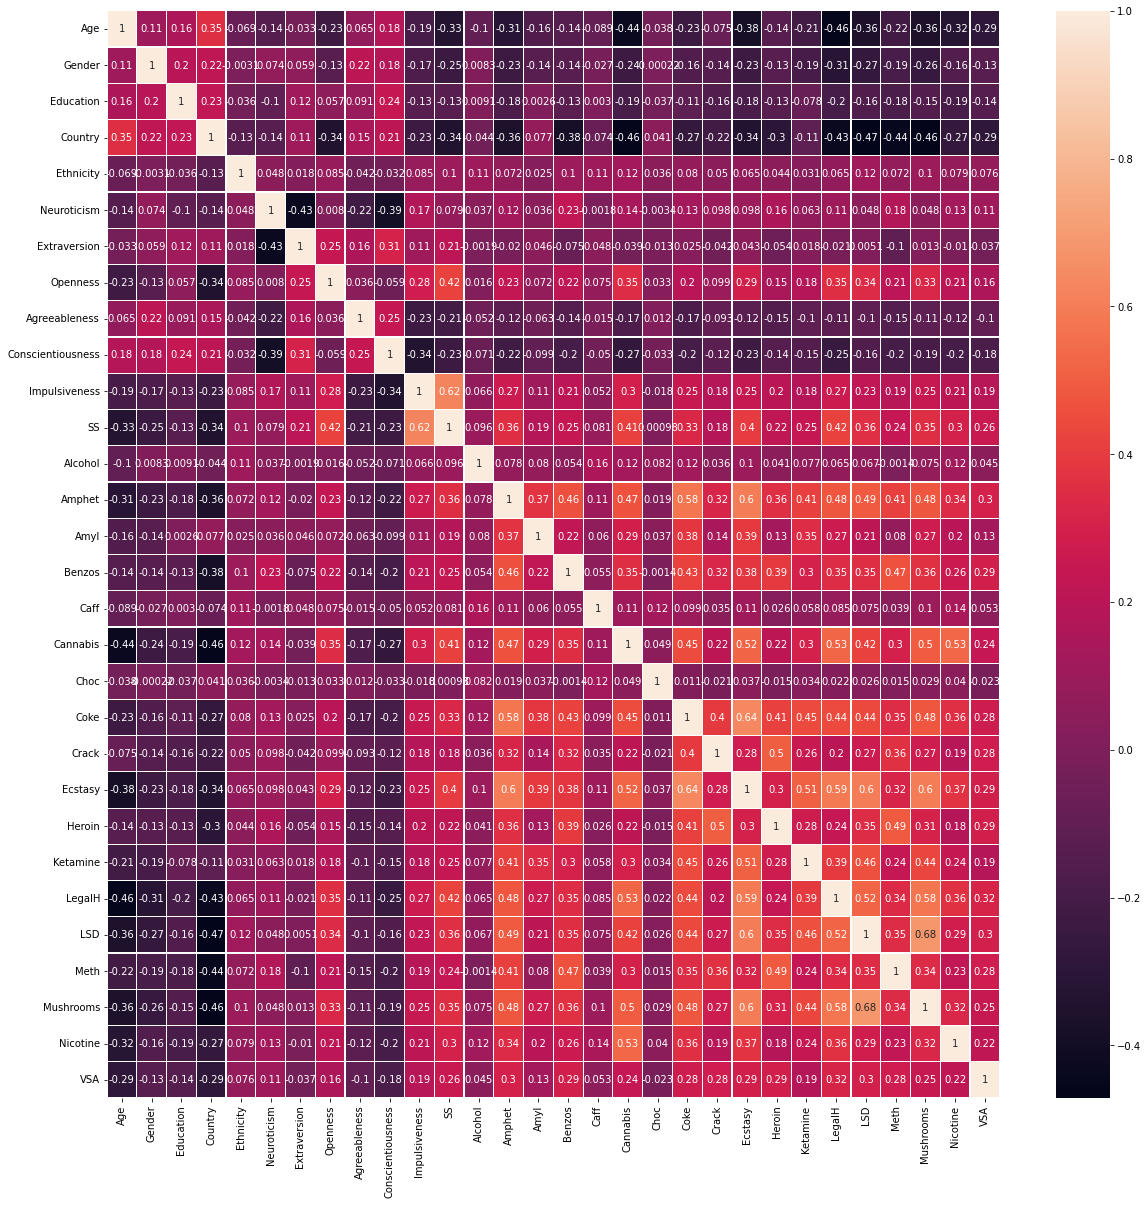

In [159]:

plt.figure(figsize=(20,20))
sns.heatmap(data.corr(),annot=True,linewidths=0.2)
plt.show()

Интересно, что употребление одних наркотических веществ коррелирует с употреблением других, напр., LSD и экстази, LSD и грибы, кокаин и экстази. 

Сначала сведем задачу к задаче бинарной классификации User/Non-User.
Если респондент употреблял какие-то наркотические вещества в последние 10 лет, то считаем, что он User.
Предлагаю исключить из рассмотрения алкоголь, шоколад и кофеин, т.к. почти все респонденты их употребляли.
Их отнесем к фичам.

In [160]:
data_user = data
data_user['User'] = int(0)
illegal_drugs = ['Amphet', 'Amyl', 'Benzos', 'Cannabis', 'Coke', 'Crack', 'Ecstasy', 'Heroin', 'Ketamine', 'LegalH', 'LSD', 
                 'Meth', 'Mushrooms', 'Nicotine', 'VSA']
for i in data_user.index:
    for drug in illegal_drugs:
        if data_user[drug][i] == 1:
            data_user['User'][i] = 1
data_user = data_user.drop(illegal_drugs, axis=1)
data_user.head()

<ipython-input-160-26152d8fe81d>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_user['User'][i] = 1


,Age,Gender,Education,Country,Ethnicity,Neuroticism,Extraversion,Openness,Agreeableness,Conscientiousness,Impulsiveness,SS,Alcohol,Caff,Choc,User
0,,,,,,,,,,,,,,,,
1,0.49788,0.48246,-0.05921,0.96082,0.12600,0.31287,-0.57545,-0.58331,-0.91699,-0.00665,-0.21712,-1.18084,1,1,1,1
2,-0.07854,-0.48246,1.98437,0.96082,-0.31685,-0.67825,1.93886,1.43533,0.76096,-0.14277,-0.71126,-0.21575,1,1,1,1
3,0.49788,-0.48246,-0.05921,0.96082,-0.31685,-0.46725,0.80523,-0.84732,-1.62090,-1.01450,-1.37983,0.40148,1,1,1,1
4,-0.95197,0.48246,1.16365,0.96082,-0.31685,-0.14882,-0.80615,-0.01928,0.59042,0.58489,-1.37983,-1.18084,1,1,1,1
5,0.49788,0.48246,1.98437,0.96082,-0.31685,0.73545,-1.63340,-0.45174,-0.30172,1.30612,-0.21712,-0.21575,1,1,1,1


In [161]:
data_user['User'].value_counts()

1    1547
0     332
Name: User, dtype: int64

Распределение значений скошено в сторону употребления веществ, судя по всему из-за никтоина и марихуаны.

# Обучим модели

In [162]:
from sklearn.linear_model import LogisticRegression # логистическая регрессия
from sklearn.linear_model import RidgeClassifier # гребневая классификация с l2 регуляризацией
from sklearn.neighbors import KNeighborsClassifier # метод ближайших соседей
from sklearn.model_selection import train_test_split # обучение и тест
from sklearn import metrics # метрика accuracy
from sklearn.metrics import confusion_matrix # матрица ошибок
from sklearn.ensemble import RandomForestClassifier # случайный лес
from sklearn.naive_bayes import GaussianNB # наивный Байес
from sklearn.model_selection import GridSearchCV 

In [163]:
X = data_user[['Age', 'Gender', 'Education', 'Country', 'Ethnicity', 'Neuroticism', 'Extraversion', 'Openness', 
               'Agreeableness', 'Conscientiousness', 'Impulsiveness', 'SS', 'Alcohol', 'Caff', 'Choc']]
y = data_user['User']
X_train,X_test,y_train,y_test = train_test_split(X, y,test_size=0.3,shuffle=True,random_state=0)

## Определим функции, которые будут писать информацию о качестве каждой модели

In [164]:
def performance_result(model, X_test, y_test):
  prediction=model.predict(X_test)
  print('Model accuracy is', metrics.accuracy_score(prediction, y_test))
  print('Model F-score', metrics.f1_score(prediction,y_test))
  print('Model Precision', metrics.precision_score(prediction,y_test))
  print('Model Recall', metrics.recall_score(prediction,y_test))
  print("Classification Report:")
  print(metrics.classification_report(y_test, prediction))
  sns.heatmap(confusion_matrix(y_test, prediction),annot=True,cmap='viridis',fmt='g')
  plt.xlabel("Предсказанное значение")
  plt.ylabel("Фактическое значение")
  

In [165]:
def roc_auc_curve(model, X_test, y_test):
  prediction=model.predict(X_test)
  roc_auc_score = metrics.roc_auc_score(y_test, prediction)
  print('Model ROC AUC=%.3f' % (roc_auc_score))
  # рассчитываем roc-кривую
  fpr, tpr, threshold = metrics.roc_curve(y_test, prediction)
  roc_auc = metrics.auc(fpr, tpr)
  plt.figure()
  plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC')
  plt.legend(loc="lower right")
  plt.show()

## Логистическая регрессия

Model accuracy is 0.824468085106383
Model F-score 0.8971962616822429
Model Precision 0.9536423841059603
Model Recall 0.8470588235294118
Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.30      0.40       111
           1       0.85      0.95      0.90       453

    accuracy                           0.82       564
   macro avg       0.73      0.63      0.65       564
weighted avg       0.80      0.82      0.80       564

Model ROC AUC=0.625


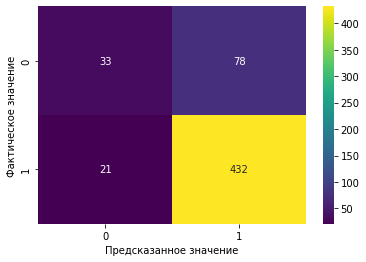

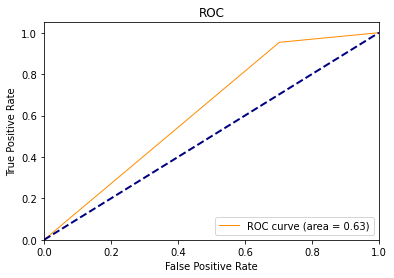

In [166]:
modelLR = LogisticRegression(random_state=1)
modelLR.fit(X_train,np.ravel(y_train))
performance_result(modelLR, X_test, y_test)
roc_auc_curve(modelLR, X_test, y_test)

## Гребневая регрессия

Model accuracy is 0.8138297872340425
Model F-score 0.8957298907646475
Model Precision 0.9955849889624724
Model Recall 0.8140794223826715
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.07      0.13       111
           1       0.81      1.00      0.90       453

    accuracy                           0.81       564
   macro avg       0.81      0.53      0.51       564
weighted avg       0.81      0.81      0.75       564

Model ROC AUC=0.534


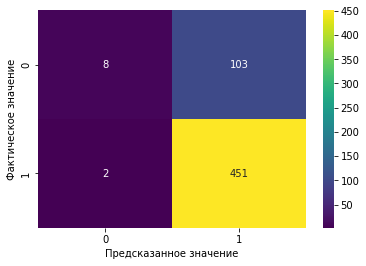

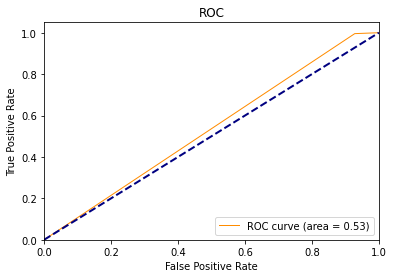

In [167]:
modelRC = RidgeClassifier(random_state=1)
modelRC.fit(X_train,np.ravel(y_train))
performance_result(modelRC, X_test, y_test)
roc_auc_curve(modelRC, X_test, y_test)

Цифры ACCURACY дают ложное представление о том, что все не так уж и плохо, но модель просто обучилась почти везде говорить 1. Цифры макро-усредненных P, R и F_Score, а также ROC_AUC это хорошо демонстрируют.

## Метод К-ближайших соседей

Model accuracy is 0.8085106382978723
Model F-score 0.8858350951374206
Model Precision 0.9249448123620309
Model Recall 0.8498985801217038
Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.33      0.41       111
           1       0.85      0.92      0.89       453

    accuracy                           0.81       564
   macro avg       0.69      0.63      0.65       564
weighted avg       0.79      0.81      0.79       564

Model ROC AUC=0.629


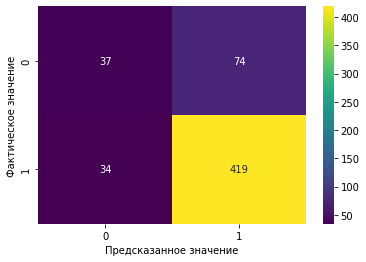

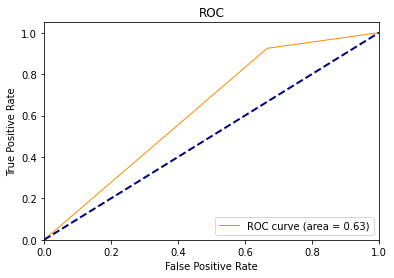

In [168]:
param_grid_KNN = {"n_neighbors": list(range(1,11)) }
modelKNN = KNeighborsClassifier()
GS_KNN = GridSearchCV(modelKNN, param_grid_KNN, cv=5)
GS_KNN.fit(X_train,y_train)
modelKNN = GS_KNN.best_estimator_
modelKNN.fit(X_train,np.ravel(y_train))
performance_result(modelKNN, X_test, y_test)
roc_auc_curve(modelKNN, X_test, y_test)

## Случайный лес

Model accuracy is 0.8297872340425532
Model F-score 0.9000000000000001
Model Precision 0.9536423841059603
Model Recall 0.8520710059171598
Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.32      0.43       111
           1       0.85      0.95      0.90       453

    accuracy                           0.83       564
   macro avg       0.74      0.64      0.66       564
weighted avg       0.81      0.83      0.81       564

Model ROC AUC=0.639


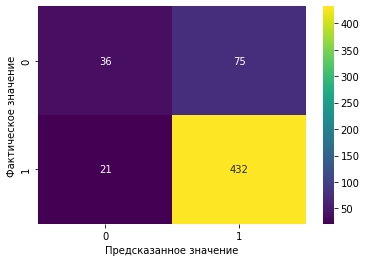

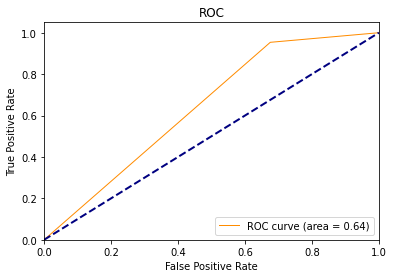

In [169]:
modelRFC = RandomForestClassifier(random_state=1)
param_grid_RFC = {"max_depth": [3, 4, 5, None], 
                   "max_features": ['sqrt', 'log2'],
                   "bootstrap": [True, False],
                   "criterion": ["gini", "entropy"],
                   "n_estimators": [20,40,60,80,100] }
GS_RFC = GridSearchCV(modelRFC, param_grid_RFC, cv=5)
GS_RFC.fit(X_train,np.ravel(y_train))
modelRFC = GS_RFC.best_estimator_
modelRFC.fit(X_train,np.ravel(y_train))
performance_result(modelRFC, X_test, y_test)
roc_auc_curve(modelRFC, X_test, y_test)

## Наивный Байес

Model accuracy is 0.8102836879432624
Model F-score 0.8785471055618616
Model Precision 0.8543046357615894
Model Recall 0.9042056074766355
Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.63      0.57       111
           1       0.90      0.85      0.88       453

    accuracy                           0.81       564
   macro avg       0.71      0.74      0.72       564
weighted avg       0.83      0.81      0.82       564

Model ROC AUC=0.742


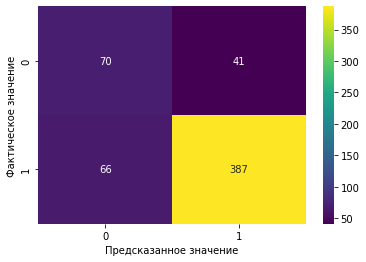

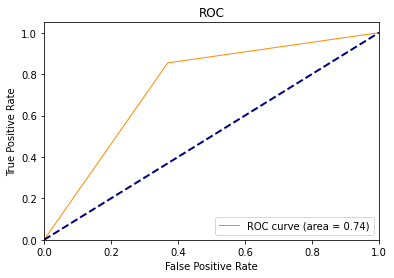

In [170]:
modelNB = GaussianNB()
modelNB.fit(X_train,np.ravel(y_train))
performance_result(modelNB, X_test, y_test)
roc_auc_curve(modelNB, X_test, y_test)

Топ-3 моделей по Accuracy:
1. Случайный лес (0.8297872340425532)
2. Логистическая регрессия (0.824468085106383)
3. Гребневая регрессия (0.8138297872340425)

Топ-3 моделей по F-мере:
1. Случайный лес (0.9000000000000001)
2. Логистическая регрессия (0.8971962616822429)
3. Гребневая регрессия (0.8957298907646475)

Топ-3 моделей по ROC-AUC:
1. Наивный Байес (0.742)
2. Случайный лес (0.639)
2. K-Nearest Neighbors (0.629)

Выводы: конечно, можно выбрать одну из моделей по той или иной метрике (из обученных моделей случайный лес справился лучше всего по двум показателям и вошел в топ-3 по третьему показателю), но все модели объединяет тот факт, что они плохо предсказывают класс Non-User (см. макро-усредненные метрики). В данных преобладает класс User, поэтому это было ожидаемо.



Предлагаю немного сменить постановку задачи.
Что поменяем:
1. Людей, которые употребляли только никотин в последние 10 лет не будем считать User-ами, никотин уйдет в фичи.
2. Категориальные фичи алкоголь, шоколад, никотин и кофеин преобразуем другим образом. 

In [171]:
# новый датасет
pd.get_dummies(drugs_df[['Alcohol', 'Caff', 'Nicotine', 'Choc']])

,Alcohol_CL0,Alcohol_CL1,Alcohol_CL2,Alcohol_CL3,Alcohol_CL4,Alcohol_CL5,Alcohol_CL6,Caff_CL0,Caff_CL1,Caff_CL2,...,Nicotine_CL4,Nicotine_CL5,Nicotine_CL6,Choc_CL0,Choc_CL1,Choc_CL2,Choc_CL3,Choc_CL4,Choc_CL5,Choc_CL6
0,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
5,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1884,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1885,0,0,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
1886,0,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1


In [172]:
data_user_2 = data.drop(['Alcohol', 'Caff', 'Nicotine', 'Choc'], axis=1)
data_user_2 = pd.concat([data_user_2, pd.get_dummies(drugs_df[['Alcohol', 'Caff', 'Nicotine', 'Choc']])], axis=1)
data_user_2['User'] = int(0)

In [173]:
data_user_2

,Age,Gender,Education,Country,Ethnicity,Neuroticism,Extraversion,Openness,Agreeableness,Conscientiousness,...,Nicotine_CL4,Nicotine_CL5,Nicotine_CL6,Choc_CL0,Choc_CL1,Choc_CL2,Choc_CL3,Choc_CL4,Choc_CL5,Choc_CL6
0,,,,,,,,,,,,,,,,,,,,,
1,0.49788,0.48246,-0.05921,0.96082,0.12600,0.31287,-0.57545,-0.58331,-0.91699,-0.00665,...,0,0,0,0,0,0,0,0,1,0
2,-0.07854,-0.48246,1.98437,0.96082,-0.31685,-0.67825,1.93886,1.43533,0.76096,-0.14277,...,1,0,0,0,0,0,0,0,0,1
3,0.49788,-0.48246,-0.05921,0.96082,-0.31685,-0.46725,0.80523,-0.84732,-1.62090,-1.01450,...,0,0,0,0,0,0,0,1,0,0
4,-0.95197,0.48246,1.16365,0.96082,-0.31685,-0.14882,-0.80615,-0.01928,0.59042,0.58489,...,0,0,0,0,0,0,0,1,0,0
5,0.49788,0.48246,1.98437,0.96082,-0.31685,0.73545,-1.63340,-0.45174,-0.30172,1.30612,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1884,-0.95197,0.48246,-0.61113,-0.57009,-0.31685,-1.19430,1.74091,1.88511,0.76096,-1.13788,...,0,0,0,0,0,0,0,1,0,0
1885,-0.95197,-0.48246,-0.61113,-0.57009,-0.31685,-0.24649,1.74091,0.58331,0.76096,-1.51840,...,0,1,0,0,0,0,0,1,0,0
1886,-0.07854,0.48246,0.45468,-0.57009,-0.31685,1.13281,-1.37639,-1.27553,-1.77200,-1.38502,...,0,0,1,0,0,0,0,0,0,1


In [174]:
illegal_drugs_2 = ['Amphet', 'Amyl', 'Benzos', 'Cannabis', 'Coke', 'Crack', 'Ecstasy', 'Heroin', 'Ketamine', 'LegalH', 'LSD', 
                 'Meth', 'Mushrooms', 'VSA']
for i in data_user_2.index:
    for drug in illegal_drugs_2:
        if data_user_2[drug][i] == 1:
            data_user_2['User'][i] = 1
data_user_2 = data_user_2.drop(illegal_drugs_2, axis=1)
data_user_2.head()

<ipython-input-174-be810ad579e6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_user_2['User'][i] = 1


,Age,Gender,Education,Country,Ethnicity,Neuroticism,Extraversion,Openness,Agreeableness,Conscientiousness,...,Nicotine_CL4,Nicotine_CL5,Nicotine_CL6,Choc_CL0,Choc_CL1,Choc_CL2,Choc_CL3,Choc_CL4,Choc_CL5,Choc_CL6
0,,,,,,,,,,,,,,,,,,,,,
1,0.49788,0.48246,-0.05921,0.96082,0.12600,0.31287,-0.57545,-0.58331,-0.91699,-0.00665,...,0,0,0,0,0,0,0,0,1,0
2,-0.07854,-0.48246,1.98437,0.96082,-0.31685,-0.67825,1.93886,1.43533,0.76096,-0.14277,...,1,0,0,0,0,0,0,0,0,1
3,0.49788,-0.48246,-0.05921,0.96082,-0.31685,-0.46725,0.80523,-0.84732,-1.62090,-1.01450,...,0,0,0,0,0,0,0,1,0,0
4,-0.95197,0.48246,1.16365,0.96082,-0.31685,-0.14882,-0.80615,-0.01928,0.59042,0.58489,...,0,0,0,0,0,0,0,1,0,0
5,0.49788,0.48246,1.98437,0.96082,-0.31685,0.73545,-1.63340,-0.45174,-0.30172,1.30612,...,0,0,0,0,0,0,0,0,0,1


In [175]:
data_user_2.columns

Index(['Age', 'Gender', 'Education', 'Country', 'Ethnicity', 'Neuroticism',
       'Extraversion', 'Openness', 'Agreeableness', 'Conscientiousness',
       'Impulsiveness', 'SS', 'User', 'Alcohol_CL0', 'Alcohol_CL1',
       'Alcohol_CL2', 'Alcohol_CL3', 'Alcohol_CL4', 'Alcohol_CL5',
       'Alcohol_CL6', 'Caff_CL0', 'Caff_CL1', 'Caff_CL2', 'Caff_CL3',
       'Caff_CL4', 'Caff_CL5', 'Caff_CL6', 'Nicotine_CL0', 'Nicotine_CL1',
       'Nicotine_CL2', 'Nicotine_CL3', 'Nicotine_CL4', 'Nicotine_CL5',
       'Nicotine_CL6', 'Choc_CL0', 'Choc_CL1', 'Choc_CL2', 'Choc_CL3',
       'Choc_CL4', 'Choc_CL5', 'Choc_CL6'],
      dtype='object')

In [205]:
X_2 = data_user_2[['Age', 'Gender', 'Education', 'Country', 'Ethnicity', 'Neuroticism',
       'Extraversion', 'Openness', 'Agreeableness', 'Conscientiousness',
       'Impulsiveness', 'SS', 'Alcohol_CL0', 'Alcohol_CL1',
       'Alcohol_CL2', 'Alcohol_CL3', 'Alcohol_CL4', 'Alcohol_CL5',
       'Alcohol_CL6', 'Caff_CL0', 'Caff_CL1', 'Caff_CL2', 'Caff_CL3',
       'Caff_CL4', 'Caff_CL5', 'Caff_CL6', 'Nicotine_CL0', 'Nicotine_CL1',
       'Nicotine_CL2', 'Nicotine_CL3', 'Nicotine_CL4', 'Nicotine_CL5',
       'Nicotine_CL6', 'Choc_CL0', 'Choc_CL1', 'Choc_CL2', 'Choc_CL3',
       'Choc_CL4', 'Choc_CL5', 'Choc_CL6']]
y_2 = data_user_2['User']

In [206]:
y_2.value_counts()

1    1412
0     467
Name: User, dtype: int64

In [207]:
X_2_train,X_2_test,y_2_train,y_2_test = train_test_split(X_2, y_2,test_size=0.3,shuffle=True,random_state=0)

Model accuracy is 0.824468085106383
Model F-score 0.8817204301075269
Model Precision 0.8978102189781022
Model Recall 0.8661971830985915
Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.63      0.66       153
           1       0.87      0.90      0.88       411

    accuracy                           0.82       564
   macro avg       0.78      0.76      0.77       564
weighted avg       0.82      0.82      0.82       564

Model ROC AUC=0.763


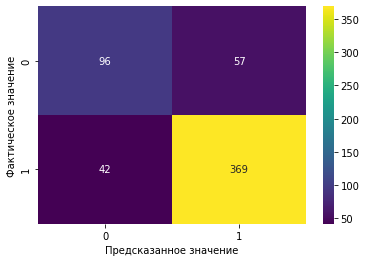

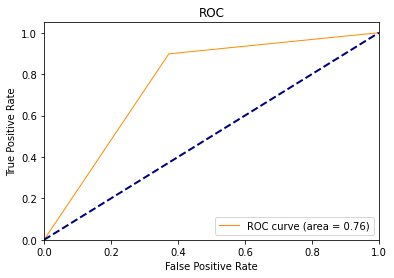

In [208]:
#логистическая регрессия
modelLR2 = LogisticRegression(random_state=1)
modelLR2.fit(X_2_train,np.ravel(y_2_train))
performance_result(modelLR2, X_2_test, y_2_test)
roc_auc_curve(modelLR2, X_2_test, y_2_test)

Model accuracy is 0.8262411347517731
Model F-score 0.8847058823529412
Model Precision 0.9148418491484185
Model Recall 0.856492027334852
Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.59      0.65       153
           1       0.86      0.91      0.88       411

    accuracy                           0.83       564
   macro avg       0.79      0.75      0.77       564
weighted avg       0.82      0.83      0.82       564

Model ROC AUC=0.752


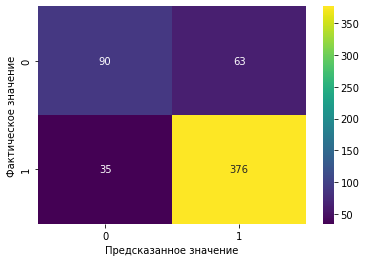

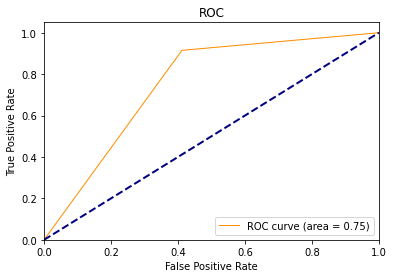

In [209]:
#гребневая регрессия 
modelRC2 = RidgeClassifier(random_state=1)
modelRC2.fit(X_2_train,np.ravel(y_2_train))
performance_result(modelRC2, X_2_test, y_2_test)
roc_auc_curve(modelRC2, X_2_test, y_2_test)

Model accuracy is 0.7836879432624113
Model F-score 0.8504901960784315
Model Precision 0.8442822384428224
Model Recall 0.8567901234567902
Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.62      0.61       153
           1       0.86      0.84      0.85       411

    accuracy                           0.78       564
   macro avg       0.73      0.73      0.73       564
weighted avg       0.79      0.78      0.78       564

Model ROC AUC=0.733


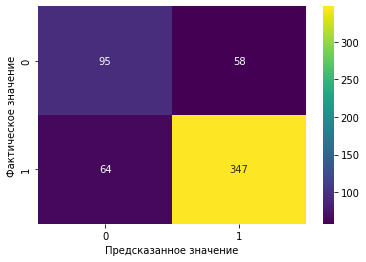

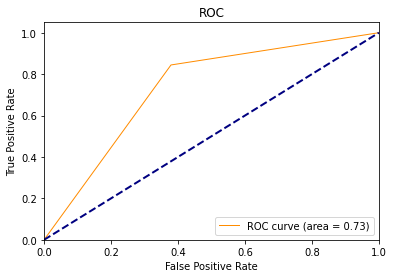

In [210]:
#KNN
modelKNN2 = KNeighborsClassifier()
GS_KNN2 = GridSearchCV(modelKNN2, param_grid_KNN, cv=5)
GS_KNN2.fit(X_2_train,y_2_train)
modelKNN2 = GS_KNN2.best_estimator_
modelKNN2.fit(X_2_train,np.ravel(y_2_train))
performance_result(modelKNN2, X_2_test, y_2_test)
roc_auc_curve(modelKNN2, X_2_test, y_2_test)

Model accuracy is 0.8404255319148937
Model F-score 0.8943661971830985
Model Precision 0.927007299270073
Model Recall 0.8639455782312925
Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.61      0.67       153
           1       0.86      0.93      0.89       411

    accuracy                           0.84       564
   macro avg       0.81      0.77      0.78       564
weighted avg       0.83      0.84      0.83       564

Model ROC AUC=0.767


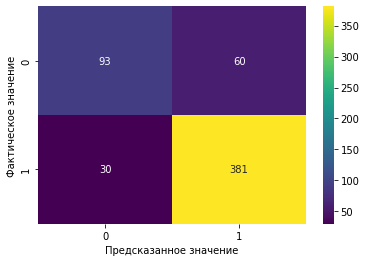

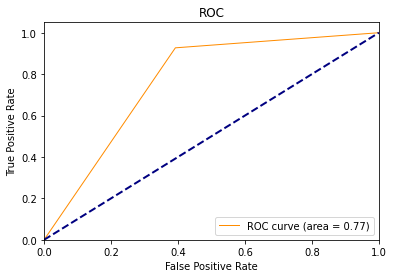

In [211]:
#случайный лес
modelRFC2 = RandomForestClassifier(random_state=1)
param_grid_RFC2 = {"max_depth": [3, 4, 5, None], 
                   "max_features": ['sqrt', 'log2'],
                   "bootstrap": [True, False],
                   "criterion": ["gini", "entropy"],
                   "n_estimators": [20,40,60,80,100] }
GS_RFC2 = GridSearchCV(modelRFC2, param_grid_RFC2, cv=5)
GS_RFC2.fit(X_2_train,np.ravel(y_2_train))
modelRFC2 = GS_RFC2.best_estimator_
modelRFC2.fit(X_2_train,np.ravel(y_2_train))
performance_result(modelRFC2, X_2_test, y_2_test)
roc_auc_curve(modelRFC2, X_2_test, y_2_test)

Model accuracy is 0.5780141843971631
Model F-score 0.6098360655737706
Model Precision 0.45255474452554745
Model Recall 0.9346733668341709
Classification Report:
              precision    recall  f1-score   support

           0       0.38      0.92      0.54       153
           1       0.93      0.45      0.61       411

    accuracy                           0.58       564
   macro avg       0.66      0.68      0.58       564
weighted avg       0.79      0.58      0.59       564

Model ROC AUC=0.684


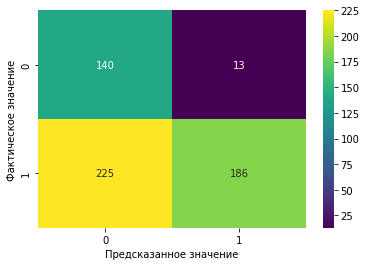

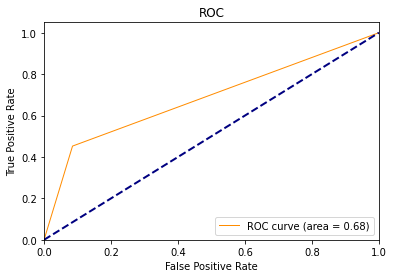

In [212]:
# Наивный Байес
modelNB2 = GaussianNB()
modelNB2.fit(X_2_train,y_2_train)
performance_result(modelNB2, X_2_test, y_2_test)
roc_auc_curve(modelNB2, X_2_test, y_2_test)

Топ-3 моделей по Accuracy:
1. Случайный лес (0.8404255319148937)
2. Гребневая регрессия (0.8262411347517731)
3. Логистическая регрессия (0.824468085106383)

Топ-3 модеелй по F-мере:
1. Случайный лес (0.8943661971830985)
2. Гребневая регрессия (0.8847058823529412)
3. Логистическая регрессия (0.8817204301075269)

Топ-3 моделей по ROC-AUC:
1. Случайный лес (0.767)
2. Логистическая регрессия (0.763)
3. Гребневая регрессия (0.752)

Получается, что с этой задачей при такой предобработке фич лучше всего справились модели случайного леса, гребневой регрессии и логистической регрессии.

Теперь предлагаю еще раз сменить постановку задачи и обучить модели определять User-ов одного вещества, например, марихуаны.

# Предсказываем User-ов конкретного вещества

In [213]:
X_c = data[['Age', 'Gender', 'Education', 'Country', 'Ethnicity', 'Neuroticism', 'Extraversion', 'Openness', 'Agreeableness', 
            'Conscientiousness', 'Impulsiveness', 'SS', 'Alcohol', 'Amphet', 'Amyl', 'Benzos', 'Caff', 'Choc',
            'Coke', 'Crack', 'Ecstasy', 'Heroin', 'Ketamine', 'LegalH', 'LSD', 'Meth', 'Mushrooms', 'Nicotine', 'VSA']]
y_c = data['Cannabis']

In [214]:
X_c_train,X_c_test,y_c_train,y_c_test = train_test_split(X_c, y_c,test_size=0.3,shuffle=True,random_state=0)

In [290]:
X_c.head()

,Age,Gender,Education,Country,Ethnicity,Neuroticism,Extraversion,Openness,Agreeableness,Conscientiousness,...,Crack,Ecstasy,Heroin,Ketamine,LegalH,LSD,Meth,Mushrooms,Nicotine,VSA
0,,,,,,,,,,,,,,,,,,,,,
1,0.49788,0.48246,-0.05921,0.96082,0.12600,0.31287,-0.57545,-0.58331,-0.91699,-0.00665,...,0,0,0,0,0,0,0,0,1,0
2,-0.07854,-0.48246,1.98437,0.96082,-0.31685,-0.67825,1.93886,1.43533,0.76096,-0.14277,...,0,1,0,1,0,1,1,0,1,0
3,0.49788,-0.48246,-0.05921,0.96082,-0.31685,-0.46725,0.80523,-0.84732,-1.62090,-1.01450,...,0,0,0,0,0,0,0,0,0,0
4,-0.95197,0.48246,1.16365,0.96082,-0.31685,-0.14882,-0.80615,-0.01928,0.59042,0.58489,...,0,0,0,1,0,0,0,0,1,0
5,0.49788,0.48246,1.98437,0.96082,-0.31685,0.73545,-1.63340,-0.45174,-0.30172,1.30612,...,0,0,0,0,0,0,0,1,1,0


## Логистическая регрессия

Model accuracy is 0.8829787234042553
Model F-score 0.9073033707865168
Model Precision 0.8947368421052632
Model Recall 0.9202279202279202
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.86      0.84       203
           1       0.92      0.89      0.91       361

    accuracy                           0.88       564
   macro avg       0.87      0.88      0.87       564
weighted avg       0.88      0.88      0.88       564

Model ROC AUC=0.878


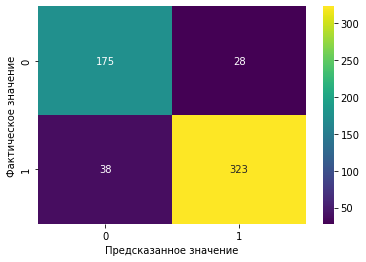

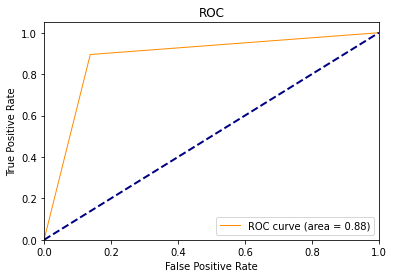

In [215]:
modelLRC = LogisticRegression(random_state=1)
modelLRC.fit(X_c_train,np.ravel(y_c_train))
performance_result(modelLRC, X_c_test, y_c_test)
roc_auc_curve(modelLRC, X_c_test, y_c_test)

## Гребневая регрессия

Model accuracy is 0.875886524822695
Model F-score 0.9014084507042254
Model Precision 0.8864265927977839
Model Recall 0.9169054441260746
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.86      0.83       203
           1       0.92      0.89      0.90       361

    accuracy                           0.88       564
   macro avg       0.86      0.87      0.87       564
weighted avg       0.88      0.88      0.88       564

Model ROC AUC=0.872


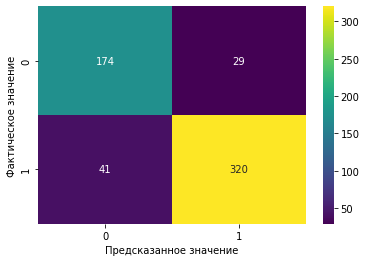

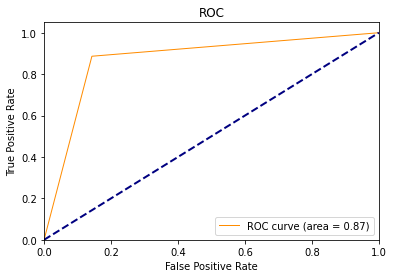

In [216]:
modelRCC = RidgeClassifier(random_state=1)
modelRCC.fit(X_c_train,np.ravel(y_c_train))
performance_result(modelRCC, X_c_test, y_c_test)
roc_auc_curve(modelRCC, X_c_test, y_c_test)

## Метод К-ближайших соседей

Model accuracy is 0.8421985815602837
Model F-score 0.8677563150074294
Model Precision 0.8088642659279779
Model Recall 0.9358974358974359
Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.90      0.80       203
           1       0.94      0.81      0.87       361

    accuracy                           0.84       564
   macro avg       0.83      0.86      0.84       564
weighted avg       0.86      0.84      0.84       564

Model ROC AUC=0.855


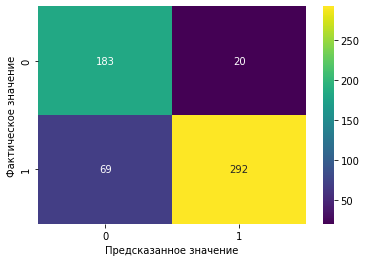

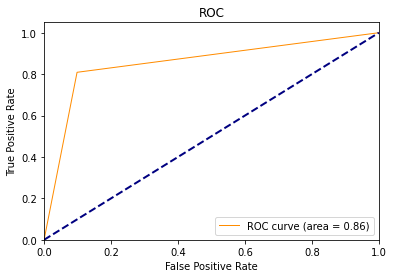

In [217]:
param_grid_KNNC = {"n_neighbors": list(range(1,11)) }
modelKNNC = KNeighborsClassifier()
GS_KNNC = GridSearchCV(modelKNNC, param_grid_KNNC, cv=5)
GS_KNNC.fit(X_c_train,y_c_train)
modelKNNC = GS_KNNC.best_estimator_
modelKNNC.fit(X_c_train,np.ravel(y_c_train))
performance_result(modelKNNC, X_c_test, y_c_test)
roc_auc_curve(modelKNNC, X_c_test, y_c_test)

## Случайный лес

Model accuracy is 0.8812056737588653
Model F-score 0.9044222539229673
Model Precision 0.8781163434903048
Model Recall 0.9323529411764706
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.89      0.84       203
           1       0.93      0.88      0.90       361

    accuracy                           0.88       564
   macro avg       0.87      0.88      0.87       564
weighted avg       0.89      0.88      0.88       564

Model ROC AUC=0.882


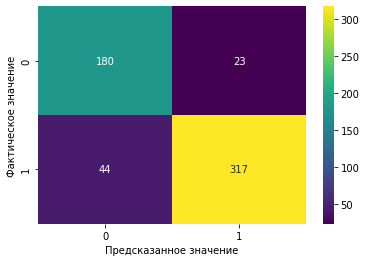

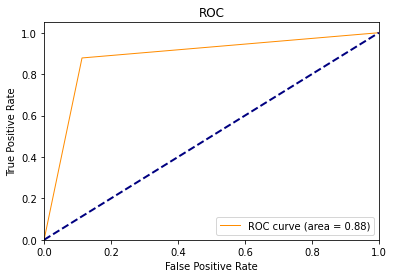

In [218]:
modelRFCC = RandomForestClassifier(random_state=1)
param_grid_RFCC = {"max_depth": [3, 4, 5, None], 
                   "max_features": ['sqrt', 'log2'],
                   "bootstrap": [True, False],
                   "criterion": ["gini", "entropy"],
                   "n_estimators": [20,40,60,80,100] }
GS_RFCC = GridSearchCV(modelRFCC, param_grid_RFCC, cv=5)
GS_RFCC.fit(X_c_train,np.ravel(y_c_train))
modelRFCC = GS_RFCC.best_estimator_
modelRFCC.fit(X_c_train,np.ravel(y_c_train))
performance_result(modelRFCC, X_c_test, y_c_test)
roc_auc_curve(modelRFCC, X_c_test, y_c_test)

In [219]:
GS_RFCC.best_estimator_.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 5,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}

## Наивный Байес

Model accuracy is 0.8475177304964538
Model F-score 0.8708708708708708
Model Precision 0.8033240997229917
Model Recall 0.9508196721311475
Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.93      0.81       203
           1       0.95      0.80      0.87       361

    accuracy                           0.85       564
   macro avg       0.84      0.86      0.84       564
weighted avg       0.87      0.85      0.85       564

Model ROC AUC=0.865


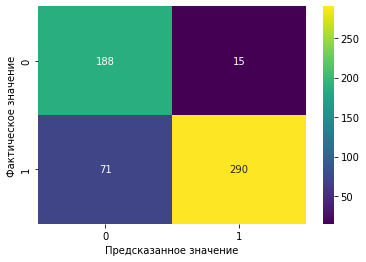

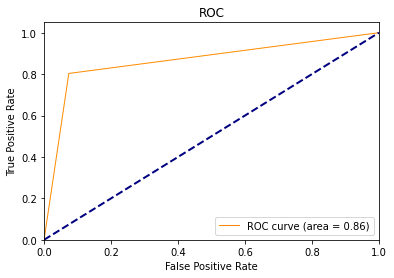

In [220]:
modelNBC = GaussianNB()
modelNBC.fit(X_c_train,np.ravel(y_c_train))
performance_result(modelNBC, X_c_test, y_c_test)
roc_auc_curve(modelNBC, X_c_test, y_c_test)

Еще не пытались использовать градиентный бустинг, что будет?

## Градиентный бустинг

In [221]:
from xgboost import XGBClassifier

In [252]:
modelBST = XGBClassifier(objective='binary:logistic')

In [253]:
param_grid_BST = {"eta": [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], 
                  "max-depth": [1,3,6,9]}
GS_BST = GridSearchCV(modelBST, param_grid_BST, cv=5)
GS_BST.fit(X_c_train,np.ravel(y_c_train))
modelBST = GS_BST.best_estimator_
modelBST.fit(X_c_train,np.ravel(y_c_train))


XGBClassifier(eta=0, max-depth=1)

Model accuracy is 0.8936170212765957
Model F-score 0.9162011173184358
Model Precision 0.9085872576177285
Model Recall 0.923943661971831
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.87      0.85       203
           1       0.92      0.91      0.92       361

    accuracy                           0.89       564
   macro avg       0.88      0.89      0.89       564
weighted avg       0.89      0.89      0.89       564

Model ROC AUC=0.888


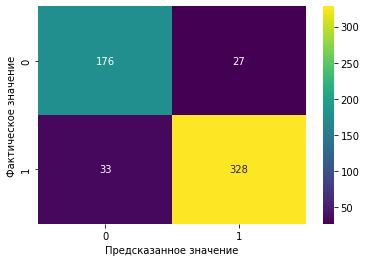

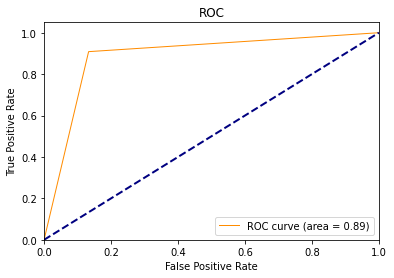

In [254]:
performance_result(modelBST, X_c_test, y_c_test)
roc_auc_curve(modelBST, X_c_test, y_c_test)

Топ-3 моделей по Accuracy:
1. Градиентный бустинг (0.8936170212765957)
2. Логистическая регрессия (0.8829787234042553)
3. Случайный лес (0.8812056737588653)

Топ-3 моделей по F-мере:
1. Градиентный бустинг (0.9162011173184358)
2. Логистическая регрессия (0.9073033707865168)
3. Случайный лес (0.9044222539229673)

Топ-3 моделей по ROC-AUC:
1. Градиентный бустинг (0.888)
2. Случайный лес (0.882)
3. Логистическая регрессия (0.878)


Такая постановка задачи представляется более адекватной. Все три модели показываю приблизительно одинаковый результат, но у градиентного бустинга все три показателя чуть выше.

Можем ли мы еще улучшить результаты? Что будет, если мы иначе преобразуем категориальные фичи?

In [255]:
X_c2 = data[['Age', 'Gender', 'Education', 'Country', 'Ethnicity', 'Neuroticism', 'Extraversion', 'Openness', 'Agreeableness', 
            'Conscientiousness', 'Impulsiveness', 'SS']]

In [256]:
X_c2 = pd.concat([X_c2, pd.get_dummies(drugs_df[['Alcohol', 'Amphet', 'Amyl', 'Benzos', 'Caff', 'Choc', 'Coke', 'Crack', 'Ecstasy', 'Heroin', 
                                                               'Ketamine', 'LegalH', 'LSD', 'Meth', 'Mushrooms', 'Nicotine', 'VSA']])], axis=1)

In [257]:
X_c2_train,X_c2_test,y_c2_train,y_c2_test = train_test_split(X_c2, y_c,test_size=0.3,shuffle=True,random_state=0)

In [258]:
X_c2_test

,Age,Gender,Education,Country,Ethnicity,Neuroticism,Extraversion,Openness,Agreeableness,Conscientiousness,...,Nicotine_CL4,Nicotine_CL5,Nicotine_CL6,VSA_CL0,VSA_CL1,VSA_CL2,VSA_CL3,VSA_CL4,VSA_CL5,VSA_CL6
0,,,,,,,,,,,,,,,,,,,,,
1001,-0.95197,-0.48246,-1.73790,-0.46841,-0.31685,1.23461,-1.09207,-0.31776,-0.15487,-0.65253,...,0,0,0,1,0,0,0,0,0,0
125,1.09449,-0.48246,-1.73790,0.96082,-0.31685,-0.34799,1.93886,0.29338,0.43852,0.58489,...,0,0,0,1,0,0,0,0,0,0
218,0.49788,-0.48246,-0.05921,0.96082,-0.31685,1.23461,0.80523,0.44585,1.45039,-1.64101,...,0,0,1,0,1,0,0,0,0,0
1431,-0.95197,-0.48246,-0.61113,-0.57009,-0.31685,-0.24649,1.45421,1.43533,-0.60633,-0.14277,...,1,0,0,1,0,0,0,0,0,0
1230,-0.95197,-0.48246,-0.61113,-0.57009,-0.22166,-1.05308,1.93886,1.24033,0.13136,0.58489,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
357,-0.07854,-0.48246,-2.43591,0.96082,-0.31685,0.62967,0.00332,1.24033,1.81866,0.93949,...,0,0,1,0,1,0,0,0,0,0
1006,-0.95197,-0.48246,-1.22751,-0.57009,-0.22166,0.82562,-1.50796,-1.82919,-0.01729,-1.64101,...,0,0,1,0,0,0,0,1,0,0
1844,1.09449,-0.48246,1.98437,0.96082,-0.31685,-0.24649,-0.80615,-0.01928,-1.62090,-0.14277,...,0,0,1,0,1,0,0,0,0,0


Model accuracy is 0.875886524822695
Model F-score 0.9011299435028248
Model Precision 0.8836565096952909
Model Recall 0.9193083573487032
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.86      0.83       203
           1       0.92      0.88      0.90       361

    accuracy                           0.88       564
   macro avg       0.86      0.87      0.87       564
weighted avg       0.88      0.88      0.88       564

Model ROC AUC=0.873


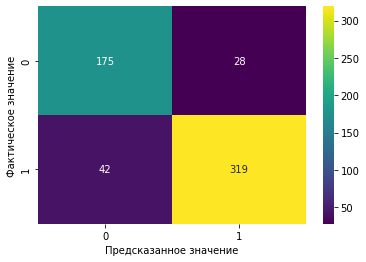

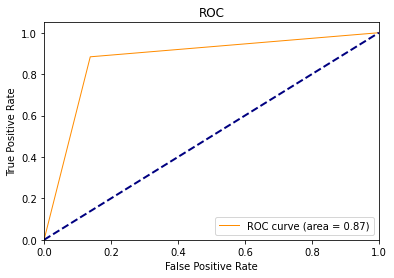

In [259]:
# логистическая регрессия
modelLRC2 = LogisticRegression(random_state=1, max_iter=200)
modelLRC2.fit(X_c2_train,np.ravel(y_c2_train))
performance_result(modelLRC2, X_c2_test, y_c2_test)
roc_auc_curve(modelLRC2, X_c2_test, y_c2_test)

Model accuracy is 0.8652482269503546
Model F-score 0.8935574229691876
Model Precision 0.8836565096952909
Model Recall 0.9036827195467422
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.83      0.82       203
           1       0.90      0.88      0.89       361

    accuracy                           0.87       564
   macro avg       0.85      0.86      0.85       564
weighted avg       0.87      0.87      0.87       564

Model ROC AUC=0.858


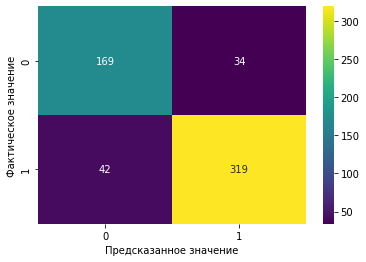

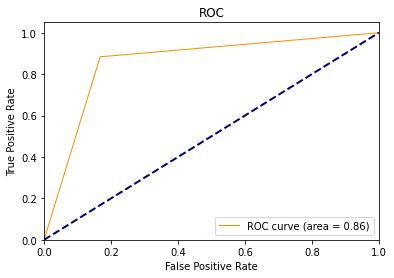

In [261]:
#случайный лес
modelRFCC2 = RandomForestClassifier(random_state=1)
param_grid_RFCC2 = {"max_depth": [3, 4, 5, None], 
                   "max_features": ['sqrt', 'log2'],
                   "bootstrap": [True, False],
                   "criterion": ["gini", "entropy"],
                   "n_estimators": [20,40,60,80,100] }
GS_RFCC2 = GridSearchCV(modelRFCC2, param_grid_RFCC2, cv=5)
GS_RFCC2.fit(X_c2_train,np.ravel(y_c2_train))
modelRFCC2 = GS_RFCC2.best_estimator_
modelRFCC2.fit(X_c2_train,np.ravel(y_c2_train))
performance_result(modelRFCC2, X_c2_test, y_c2_test)
roc_auc_curve(modelRFCC2, X_c2_test, y_c2_test)

Model accuracy is 0.8953900709219859
Model F-score 0.9177126917712692
Model Precision 0.9113573407202216
Model Recall 0.9241573033707865
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.87      0.86       203
           1       0.92      0.91      0.92       361

    accuracy                           0.90       564
   macro avg       0.89      0.89      0.89       564
weighted avg       0.90      0.90      0.90       564

Model ROC AUC=0.889


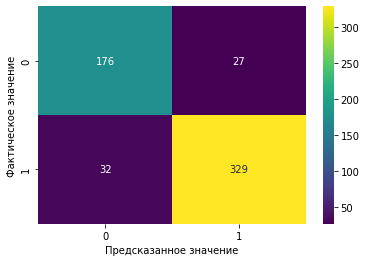

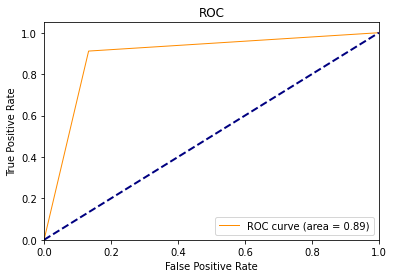

In [262]:
# градиентный бустинг
modelBST2 = XGBClassifier(objective='binary:logistic')
GS_BST2 = GridSearchCV(modelBST2, param_grid_BST, cv=5)
GS_BST2.fit(X_c2_train,np.ravel(y_c2_train))
modelBST2 = GS_BST2.best_estimator_
modelBST2.fit(X_c2_train,np.ravel(y_c2_train))
performance_result(modelBST2, X_c2_test, y_c2_test)
roc_auc_curve(modelBST2, X_c2_test, y_c2_test)

У модели градиентного бустинга есть небольшое увеличение качества по всем трем метрикам.

Еще мы можем иначе обработать категориальные фичи. До этого мы делали аналог OneHotEncoding-а, можно попробовать сделать LabelEncoding и затем скалировать фичи.

In [271]:
X_c3 = data[['Age', 'Gender', 'Education', 'Country', 'Ethnicity', 'Neuroticism', 'Extraversion', 'Openness', 'Agreeableness', 
            'Conscientiousness', 'Impulsiveness', 'SS']]

In [273]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

In [275]:
le = LabelEncoder()

In [278]:
drugs_df_encoded = drugs_df[['Alcohol', 'Amphet', 'Amyl', 'Benzos', 'Caff', 'Choc', 'Coke', 'Crack', 'Ecstasy', 'Heroin', 'Ketamine', 'LegalH', 'LSD', 'Meth', 'Mushrooms', 'Nicotine', 'VSA']]
for drug in drugs_df_encoded.columns:
  drugs_df_encoded[drug] = le.fit_transform(drugs_df[drug])


<ipython-input-278-c17132955696>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  drugs_df_encoded[drug] = le.fit_transform(drugs_df[drug])


In [280]:
X_c3=pd.concat([X_c3, drugs_df_encoded], axis=1)

In [282]:
scaler = StandardScaler()

In [283]:
X_c3 = scaler.fit_transform(X_c3)

In [287]:
X_c3[0]

array([ 0.52529597,  1.00159787, -0.05979385,  0.86141957,  2.62303643,
        0.3135497 , -0.57627916, -0.5838464 , -0.91877393, -0.00605987,
       -0.23399831, -1.22057649,  0.27344922,  0.37067187, -0.57006579,
        0.28745459,  0.46230121, -0.1004485 , -0.7657015 , -0.35449731,
       -0.79618763, -0.36057619, -0.46491198, -0.75688907, -0.70970342,
       -0.50186155, -0.80815275, -0.49544596, -0.44917177])

In [284]:
X_c3_train,X_c3_test,y_c3_train,y_c3_test = train_test_split(X_c3, y_c,test_size=0.3,shuffle=True,random_state=0)

Model accuracy is 0.874113475177305
Model F-score 0.9006993006993007
Model Precision 0.8919667590027701
Model Recall 0.9096045197740112
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.84      0.83       203
           1       0.91      0.89      0.90       361

    accuracy                           0.87       564
   macro avg       0.86      0.87      0.86       564
weighted avg       0.88      0.87      0.87       564

Model ROC AUC=0.867


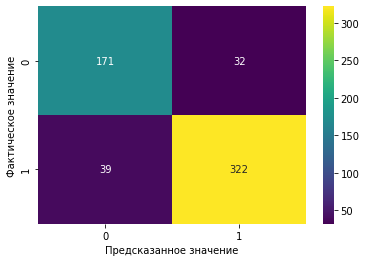

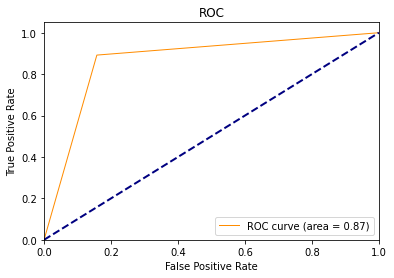

In [289]:
# логистическая регрессия
modelLRC3 = LogisticRegression(random_state=1)
modelLRC3.fit(X_c3_train,np.ravel(y_c3_train))
performance_result(modelLRC3, X_c3_test, y_c3_test)
roc_auc_curve(modelLRC3, X_c3_test, y_c3_test)

Model accuracy is 0.8865248226950354
Model F-score 0.9103641456582633
Model Precision 0.9002770083102493
Model Recall 0.9206798866855525
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.86      0.85       203
           1       0.92      0.90      0.91       361

    accuracy                           0.89       564
   macro avg       0.88      0.88      0.88       564
weighted avg       0.89      0.89      0.89       564

Model ROC AUC=0.881


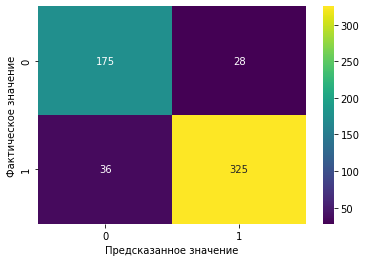

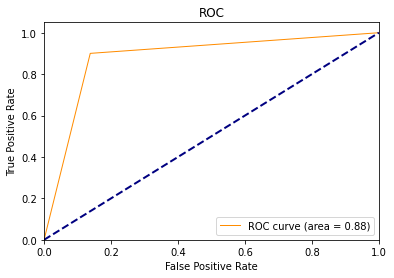

In [288]:
#случайный лес
modelRFCC3 = RandomForestClassifier(random_state=1)
GS_RFCC3 = GridSearchCV(modelRFCC3, param_grid_RFCC2, cv=5)
GS_RFCC3.fit(X_c3_train,np.ravel(y_c3_train))
modelRFCC3 = GS_RFCC3.best_estimator_
modelRFCC3.fit(X_c3_train,np.ravel(y_c3_train))
performance_result(modelRFCC3, X_c3_test, y_c3_test)
roc_auc_curve(modelRFCC3, X_c3_test, y_c3_test)

Model accuracy is 0.8882978723404256
Model F-score 0.9121338912133891
Model Precision 0.9058171745152355
Model Recall 0.9185393258426966
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.86      0.85       203
           1       0.92      0.91      0.91       361

    accuracy                           0.89       564
   macro avg       0.88      0.88      0.88       564
weighted avg       0.89      0.89      0.89       564

Model ROC AUC=0.881


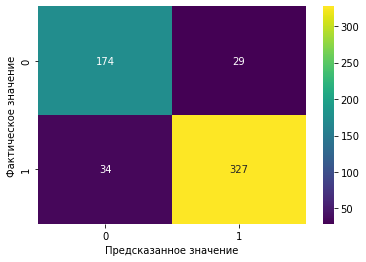

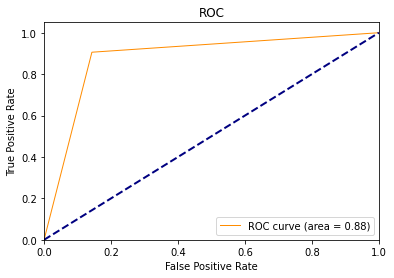

In [285]:
# градиентный бустинг
modelBST3 = XGBClassifier(objective='binary:logistic')
GS_BST3 = GridSearchCV(modelBST3, param_grid_BST, cv=5)
GS_BST3.fit(X_c3_train,np.ravel(y_c3_train))
modelBST3 = GS_BST3.best_estimator_
modelBST3.fit(X_c3_train,np.ravel(y_c3_train))
performance_result(modelBST3, X_c3_test, y_c3_test)
roc_auc_curve(modelBST3, X_c3_test, y_c3_test)

Качество не улучшилось.

**Общие выводы:**
* Было предложено 3 варианта задачи бинарной классификации, основанных на следующем комментарии к датасету: «Problem can be transformed to binary classification by union of part of classes into one new class. For example, "Never Used", "Used over a Decade Ago" form class "Non-user" and all other classes form class "User"».
 1. Первая задача: предсказание того, что человек употреблял хотя бы одно вещество из списка (кроме алкоголя, шоколада, кофеина) за последние 10 лет.
 2. Вторая задача: предсказание того, что человек употреблял хотя бы одно вещество из списка (кроме алкоголя, шоколада, кофеина, никотина) за последние 10 лет.
 3. Третья задача: предсказание того, что человек употреблял марихуану за последние 10 лет.
* В качестве валидирующих метрик были выбраны: accuracy, F-мера, ROC-AUC. 
* Для решения первой задачи значения категориальных признаков Alcohol, Caff, Choc были преобразованы в 0 и 1 согласно комментарию к датасету. Данные были смещены в сторону класса User. Были обучены следующие модели: логистическая регрессия, гребневая регрессия, метод K-ближайших соседей, случайный лес, наивный Байес. Лучшие результаты по набору из трех метрик продемонстрировала модель случайного леса. 
* Для решения второй задачи категориальные фичи Alcohol, Caff, Choc, Nicotine (!) были преобразованы методом get_dummies() библиотеки pandas (аналогично sklearn-овскому OneHotEncoder). Были обучены следующие модели: логистическая регрессия, гребневая регрессия, случайный лес, метод K-ближайших соседей и наивный байесовский классификатор. Лучшие результаты по трем метрикам снова продемонстрировала модель логистической случайного леса. Две другие модели в топ-3 по трем метрикам - это логистическая регрессия и гребневая регрессия. По всем моделям возросло значение метрики ROC-AUC.
* Для решения третьей задачи было выбрано одно вещество, которое стало целевым классом: Cannabis. Было произведено несколько опытов.
	* Значения категориальных признаков были преобразованы в 0 и 1. Были обучены следующие модели: логистическая регрессия, гребневая регрессия, метод K-ближайших соседей, случайный лес, наивный Байес, гадиентный бустинг. Лучшее качество по всем трем метрикам качества продемонстировала модель градиентного бустинга. Другие модели в топ-3: логистическая регрессия, случайный лес. 
	* Для преобразования значений категориальных фич был использован аналог OneHotEncoder-а (метод get_dummies()). Были обучены модели логистической регрессии, случайного леса, градиентного бустинга. Модель гардиентного бустинга достигла небольшого увеличесния качества по всем трем метрикам.
	* Для преобразования значений категориальных фич был использован LabelEncoder, затем все фичи были скалированы. Были обучены модели логистической регрессии, случайного леса и градиентного бустинга. Такой подход не дал улучшения качества.



# Multilabel Classification

Таргет: User/Non-User каждого из веществ

In [58]:
X_m = data[['Age', 'Gender', 'Education', 'Country', 'Ethnicity', 'Neuroticism', 'Extraversion', 'Openness', 'Agreeableness', 
            'Conscientiousness', 'Impulsiveness', 'SS', 'Alcohol', 'Caff', 'Choc','Nicotine']]
y_m =data[illegal_drugs]

In [59]:
X_m_train,X_m_test,y_m_train,y_m_test = train_test_split(X_m, y_m,test_size=0.3,shuffle=True,random_state=0)

## Случайный лес

In [60]:
modelRFCM = RandomForestClassifier()
param_grid_RFCM = {"max_depth": [3, 4, 5, None], 
                   "max_features": ['sqrt', 'log2'],
                   "bootstrap": [True, False],
                   "criterion": ["gini", "entropy"],
                   "n_estimators": [20,40,60,80,100] }
GS_RFCM = GridSearchCV(modelRFCM, param_grid_RFCM, cv=5)
GS_RFCM.fit(X_m_train,y_m_train)
modelRFCM = GS_RFCM.best_estimator_
predictionRFCM=modelRFCM.predict(X_m_test)


Random Forest Classifier Accuracy 0.24558303886925795


In [61]:
print('Micro Avg metrics:')
print('Random Forest Classifier Micro Avg Precision', metrics.precision_score(predictionRFCM,y_m_test, average='micro'))
print('Random Forest Classifier Micro Avg Precision', metrics.recall_score(predictionRFCM,y_m_test, average='micro'))
print('Random Forest Classifier Micro Avg F1-score', metrics.f1_score(predictionRFCM,y_m_test, average='micro'))

Micro Avg metrics:
Random Forest Classifier Micro Avg Precision 0.6448809973554968
Random Forest Classifier Micro Avg Precision 0.7184343434343434
Random Forest Classifier Micro Avg F1-score 0.6796735018913


In [62]:
print('Macro Avg Metrics:')
print('Random Forest Classifier Macro Avg Precision', metrics.precision_score(predictionRFCM,y_m_test, average='macro'))
print('Random Forest Classifier Macro Avg Precision', metrics.recall_score(predictionRFCM,y_m_test, average='macro'))
print('Random Forest Classifier Macro Avg F1-score', metrics.f1_score(predictionRFCM,y_m_test, average='macro'))

Macro Avg Metrics:
Random Forest Classifier Macro Avg Precision 0.46621465221946945
Random Forest Classifier Macro Avg Precision 0.56003886266745
Random Forest Classifier Macro Avg F1-score 0.49086399807460007


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Метод K-ближайших соседей

In [63]:
param_grid_KNNM = {"n_neighbors": list(range(1,11)) }
modelKNNM = KNeighborsClassifier()
GS_KNNM = GridSearchCV(modelKNNM, param_grid_KNNM, cv=5)
GS_KNNM.fit(X_m_train,y_m_train)
modelKNNM = GS_KNNM.best_estimator_
modelKNNM.fit(X_m_train,y_m_train)
predictionKNNM=modelKNNM.predict(X_m_test)

In [64]:
print('Micro Avg metrics:')
print('K-Nearest Neighbors Micro Avg Precision', metrics.precision_score(predictionKNNM,y_m_test, average='micro'))
print('K-Nearest Neighbors Micro Avg Precision', metrics.recall_score(predictionKNNM,y_m_test, average='micro'))
print('K-Nearest Neighbors Micro Avg F1-score', metrics.f1_score(predictionKNNM,y_m_test, average='micro'))

Micro Avg metrics:
K-Nearest Neighbors Micro Avg Precision 0.5848129958443521
K-Nearest Neighbors Micro Avg Precision 0.7277856135401974
K-Nearest Neighbors Micro Avg F1-score 0.6485127775450357


In [65]:
print('Macro Avg metrics:')
print('K-Nearest Neighbors Macro Avg Precision', metrics.precision_score(predictionKNNM,y_m_test, average='macro'))
print('K-Nearest Neighbors Macro Avg Precision', metrics.recall_score(predictionKNNM,y_m_test, average='macro'))
print('K-Nearest Neighbors Macro Avg F1-score', metrics.f1_score(predictionKNNM,y_m_test, average='macro'))

Macro Avg metrics:
K-Nearest Neighbors Macro Avg Precision 0.4072559340672593
K-Nearest Neighbors Macro Avg Precision 0.5662327731789432
K-Nearest Neighbors Macro Avg F1-score 0.4432535359965809


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Гребневая регрессия

In [66]:
modelRCM = RidgeClassifier(random_state=1)
modelRCM.fit(X_m_train,y_m_train)
predictionRCM=modelRCM.predict(X_m_test)

In [67]:
print('Micro Avg metrics:')
print('Ridge Classifier Micro Avg Precision', metrics.precision_score(predictionRCM,y_m_test, average='micro'))
print('Ridge Classifier Micro Avg Precision', metrics.recall_score(predictionRCM,y_m_test, average='micro'))
print('Ridge Classifier Micro Avg F1-score', metrics.f1_score(predictionRCM,y_m_test, average='micro'))

Micro Avg metrics:
Ridge Classifier Micro Avg Precision 0.6278806195693237
Ridge Classifier Micro Avg Precision 0.7479747974797479
Ridge Classifier Micro Avg F1-score 0.6826863832409118


In [68]:
print('Macro Avg metrics:')
print('Ridge Classifier Macro Avg Precision', metrics.precision_score(predictionRCM,y_m_test, average='macro'))
print('Ridge Classifier Macro Avg Precision', metrics.recall_score(predictionRCM,y_m_test, average='macro'))
print('Ridge Classifier Macro Avg F1-score', metrics.f1_score(predictionRCM,y_m_test, average='macro'))

Macro Avg metrics:
Ridge Classifier Macro Avg Precision 0.42464801546745257
Ridge Classifier Macro Avg Precision 0.4606447171861108
Ridge Classifier Macro Avg F1-score 0.43149559625266715


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### **Задание №4**. Предположим, что мы построили рекомендательную систему, и ожидаем, что средний чек клиента вследствие этого должен вырасти. Мы провели AB-тест и собрали данные по контрольной и тестовой группе. Предложите и проведите статистический тест, который можно применить к этим данным.

В процессе выполнения задания разрешено пользоваться библиотеками scipy и statsmodels.

In [2]:
import numpy as np

# Сгенерируем данные для задачи
control = np.random.lognormal(mean=5, sigma=2, size=(100000,))
test = np.random.lognormal(mean=5.04, sigma=2, size=(100000,))

In [3]:
# <YOUR_CODE_HERE>
# Для сравнения средних используем t-критерий Стьюдента, пусть уровень значимости 0.05
# Тест требует нормального распределения выборочных средних
# Критерий можем использовать, т.к. у нас много наблюдений

from scipy.stats import ttest_ind
t_stat, p_value = ttest_ind(control, test)
print("T-statistic value: ", t_stat)  
print("P-Value: ", p_value)

T-statistic value:  -2.556719140661
P-Value:  0.01056718087175811


Мы выбрали уровень значимости 0.05, p-value оказалось меньше 0.05, отвергаем гипотезу о равенстве средних этих двух выборок, разница средних оказалась статистически значимой.

### **Задание №4 (*)**. В прошлом задании мы улавливали статистически значимое различие в средних в 0.04 единицы на выборке из 100000 клиентов. Насколько больше нам требуется собрать клиентов, чтобы уловить различие в 0.02?

In [ ]:
# <YOUR_CODE_HERE>